![title](./03_image/epfl-swt.png)


# Capstone Project by Bertrand Zahno

# Predicting Tennis Rankings with Swisstennis Data

## 1) The problem

Swisstennis (SWT) is the organization that leads the entire tennis business in Switzerland. Under the care of it, all tennis tournaments and interclub matches (these are matches where one club encounters another, a sort of a "davis cup" like manifestation) are coordinated. SWT is responsible to classify each licensed player. Each player gets a ranking according to his performance over the last 12 months which is calculated twice a year. The last list was evaluated and published beginning of october 2019.

To the competing players this is tremendeously important as it may allow to play in higher ranked ligues and tournaments.

During the year and after having played matches, the players are eager to know what would be their new ranking for the upcoming periode. Unless the ATP (the professional world-wide organization of Tennis), which publishes the new ATP world ranking list on a weekly basis, SWT only publishes the new ranking twice a year. For this purpose SWT installed a paying SMS service, where at any time, the players can get their "current" ranking, based on their recent results. Each request costs 2.50 CHF for each player. This is a popular service used by most of the players competing regularly.

I was now wondering, if such a service could also be proposed using techniques from machine learning.

So how does SWT calculate their ranking ? All the details can be found at ART.5 of https://www.swisstennis.ch/sites/default/files/2019_klassierungsrichtlinien_f.pdf

**In a nutshell:**  (see a sample player to verify: https://www.swisstennis.ch/fr/user/12172/results-summary)
* each player gets a ranking (in this example it is: R1 and is the current number "207" in the overall ranking). This ranking depends on the general ranking  or grading value ("Valeur de classement" which in this case is 9.777) that is composed of the competition value ("Valeur de compétition: 9.15) and the "risk award value" ("Surprime de risque:" 0.627). So 9.777 = 9.15 + 0.627.
* the competition values are calculated for alle the players in Switzerland with the following formula: (see ART 5. mentionned above).

![title](./03_image/compvalue_formula.png)

where wj are the competition values of the players.
And the formula for the risk value is as follows:
![title](./03_image/riskvalue_formula.png)

So with both formulas the risk value and the competition value are supposed to be calculated. Adding those two numbers result in the final ranking or grading value. The final ranking is a function of this grading value and expressed as follows: from N1 to N4 and R1 to R9. For instance the 10 best players of the country have a ranking N1 and have a ranking number from 1 to 10. Number 1 = Roger Federer, number 2 = Stan Wawrinka ... until the very beginners which have number around 40'000.


So having all that information, one could say: just use this formula, there is no need to use machine learning. Yes, but ... trying to do one calculation of a new competition value shows, that the result does not fit the input values with those formulas. I mentionned this to Swisstennis and they (or at least the progammer of the software) are aware, that this formula cannot be applied 1:1, as they use, I call it like this, some "hidden magic" which is not published to streamline the whole ranking scale.

So let us see if we can do better than the formula and bypass this "hidden magic" by applying regression techniques. The goal is to do better predictions of the new competition value which will be discussed in detail. At the end I will also do predictions for the risk award and the final grading value. But not the same thorough investigations will be made for those two values. The risk award should be very similar to the competition value and the only difference should only be by a linear constanct factor. Well, in reality this is not the case.

`The notebook is organized as follows:`

2. **The data:** to get a better overview and comprehension of the data I will give some interesting insights of the data like category and age distribution, number of players etc. About data quality and completeness:
Swisstennis provides proportions and numbers for each ranking category. This will be compared to the collected dataset and differences will be commented.
3. **Goal:** After having gotten a first impression of the collected data, elaborate the goal of the project.
4. **Data preparation**.
5. **First Analysis:** A first Analysis with a neural network, a random forest and ridge regressor is done to predict the new competiton value. It is compared to the baseline.
6. **Data Analysis:**  Compare the predictions with the baseline. Further discussion of the Swisstennis formula and their behaviour. Try additional feature engineering and analyze the results. Discuss the input and output variables.
7. **Second Analysis:** of the competition value: calculate on how the newly created features contribute to the result.
7. **Some more feature engineering:** Some other tries, but which did not improve the accuracy.
9. **Risk Award** pretends to be a slight different formula, do a short analysis for this value.
10. Do the same for the final **grading value**
11. **Other dataset:** I collected another dataset from 2018. Verify if the given model from the periode 2-2019 can be used to predict the rankings from other seasons.
12. **Final conclusion.**

The execution time of this whole notebook on a 4-core PC can last up to 25 minutes. There is a lot of python code in this notebook and the main data processing functions are implemented in functions in order to be used several times for different features and predictions. The sections marked as "supportive functions" can be skipped by the reader, just helper functions to build the features.


## 2) The data

### 2.1) First overview of the data

There is no flat dataset available. All we have is the webportal from Swisstennis. The starting point is usually https://www.swisstennis.ch/fr/player-search where you find a licensed player by name and find all the results from the last ranking periode and the current played matches. There is also no list available for all the licensed players.

What I need are all the matches for all the players. The solution here is to do screen scraping for all the pages of all the players. Once I have all the (html) files of all the players, the html file needs to be parsed to extract all the necessary information from the csv files. Some sample html files can be found in the subfolder 02/sample. All the files take 6 GB of diskspace.

I already did in the past a part of this swisstennis screen scraping which I am going to enhance and reuse.

Further Information of the java project is given in the readme file. The output of this screen scraping are two input files.

Let us have a look to the input csv files. The first one is the `players-2-2019.csv`. It contains the following fields:
* comp_value: the competition value as a float for the calculation in the formula above
* first_name / last_name: Name of the player
* current_periode: 2/2019, that means it is the second time this year, the ranking was calculated 
* grading_value: the overall grading value of the player (comp_value + risk_value)
* last_updated_at: when the java programm did the html parsing for the last time.
* licence_number: a key for the player.
* previous_ranking: the ranking the player had before october 2019 (in the periode 1/2019). From the SWT article above you can see, that ranking goes from N1 - N4 (the first 150 players of Switzerland), and then from R1-R9. The higher the number the "worse" the ranking.
* previous_ranking_number: all the licensed player have also an internal number throughout the whole country. (there is a bug in my code, this number is far too low in the example below, it should be around 31000 for the first player in the list).
* ranking: current ranking
* ranking_number: current ranking number.
* swisstennis_id: the key I will be using. If you want to see the results for a player on the SWT website, you can use this id, for instance for the first player in the list below: https://www.swisstennis.ch/fr/user/131078/results-summary

Now load the data:

In [1]:
import pandas as pd
import numpy as np
data_p = pd.read_csv('04_data/players-2-2019.csv', encoding = "utf-8")
print('Shape of players data:', data_p.shape)

# remove the columns not needed
data_p = data_p.drop(['id','last_updated_at'], axis=1)
data_p.head(3)

Shape of players data: (78718, 16)


,comp_value,current_periode,first_name,grading_value,last_name,licence_number,member_ship,previous_ranking,previous_ranking_number,ranking,ranking_number,swisstennis_id,age_category,licence_status
0,2.175,2/2019,Nadja,2.436,Piontek,717.68.719.0,Kloten,R7,7310,R7,5660,131075,50+,aktiv
1,0.750,2/2019,Sébastien,0.750,Reuge,737.83.239.0,Lancy-Fraisiers,R9,31800,R9,33575,131078,35+,suspendiert
2,0.750,2/2019,Marco,0.750,Bärtsch,139.85.156.0,Pizol,R8,27344,R9,33575,131076,A,suspendiert


So from the dataframe above we see in this sample: The first player in this list is named Nadja Piontek:
- She has a ranking of R7 which was already here ranking in the previous ranking periode (column "previous_ranking"). 
- Her overall ranking number within Switzerland is 7370. 
- Her age-category is "50+", she has an actif licence which allows her to play. 
- Her current competition-value is "2.175", the grading-value is "2.436", so the risk-award is: "2.436-2.175 = 0.261"
- Licence Number is 717.68.719.0 and she is a member of the Kloten Tennis-club.
- Her licence is active which enables her to play matches

The second file is `matches-2-2019.csv`, which contains all the matches played during the periode from first of october 2018 to 30th of september 2019. An overview of the data fields:
* date: when the match was played
* player1id: the swisstennis_id from the winning player
* player1name: firstname and name of the player who won the match
* comp_value1: the competition value of player1 when they played the match (so during the periode 1/2019)
* player2id, player2name, comp_value2: dito for player2 who lost the match.
* score: score of the match
* victory: the winning player is always player1, "S" stands for "Sieg" -> victory. If this value is empty, player1 won without playing, a so called w.o (walk over). 
* the other fields are obvious

Load the match data:

In [2]:
data_m = pd.read_csv('04_data/matches-2-2019.csv', encoding = "utf-8")
print('Shape of matches data:', data_p.shape)
data_m.head(2)

Shape of matches data: (78718, 14)


,date,player1id,player1name,comp_value1,player2id,player2name,comp_value2,score,victory,ranking1,ranking2,score_1,sets_lost,sets_won,url
0,2019-08-24 00:00:00.0,13781,Maurer Patrick,1.522,145472,Holzer Roger,0.43,6:2 6:1,S,R8,R9,6:2 6:1,0,2,https://comp.swisstennis.ch/advantage/servlet/...
1,2019-07-14 00:00:00.0,104283,Vildeuil Arthur,4.488,114580,Neuhaus Baptiste,3.63,6:3 5:7 7:5,S,R5,R6,6:3 5:7 7:5,1,2,https://comp.swisstennis.ch/advantage/servlet/...


So from the dataframe above we see in the first row: 
Patrick Maurer with his Swisstennis-Id 13781 and the (previous) competition value of 1.522 won against Roger Holzer (id = 145472) with the (previous) competition value of 0.43:  6/2 6/1 on 24th of august 2019.


There are different status of the licence, let's see what all we got:


In [3]:
data_p.licence_status.unique()

array(['aktiv', 'suspendiert', 'gelöscht'], dtype=object)

* "suspendiert": the corresponding player is not allowed to play official matches
* "aktiv": valid playing status, only this status allows to participate on tournaments
* "gelöscht": after not having played after a certain amount of time, this status is set.

The next function distinguishes men and women players. Thanks to the "AHV number" which is equal to the licence number and encodes the gender. The file ahv-list2.csv is from: https://www.ahv-iv.ch/de/Kontakte/Kantonale-Ausgleichskassen

In [4]:
# read the ahv list, which enable to distinguish between male and female players
df_ahv  = pd.read_csv('04_data/ahv-list2.csv', sep=';')
men_set = df_ahv.mann.values
woman_set = df_ahv.frau.values

# detects from the licence number if the player is male or female
def get_gender(lic_num):
    nbr = int(lic_num[7:10])
    if nbr in men_set:
        return 1  
    if nbr in woman_set:
        return 2
    return 3

# get the gender of each player
data_p['gender'] = data_p['licence_number'].apply(get_gender)

df = data_p[data_p['gender'] == 2]
swt_id_woman = set(df['swisstennis_id'].values.tolist())

# evaluates if a match is of type "male" or "female", I am studying only male matches, the other ones are filtered out
def get_gender_of_match(df):

    p1_id = df['player1id']
    p2_id = df['player2id']
    
    if p1_id < 0:
        if p2_id in swt_id_woman:
            return 2
        else:
            return 1
    else:
        if p1_id in swt_id_woman:
            return 2
        else:
            return 1   

### 2.2) Overview of the player data

Process the players data and print some statistics:

In [5]:
import matplotlib.pyplot as plt

# get the gender of each player
data_p['gender'] = data_p['licence_number'].apply(get_gender)

nbr_p_read = len(data_p)

# get the actif players
data_p = data_p[data_p.licence_status == 'aktiv']
nbr_actif = len(data_p)

# get only the men players
data_p = data_p[data_p['gender'] == 1]

print('Number of players read from file: ', nbr_p_read)
print('Number of actif players         : ', nbr_actif)
print('Number of men players           : ', len(data_p))
print('Number of ladies players        : ', nbr_actif - len(data_p))

objects = ('# all players from file', '# actif players', '# of men players', '# of ladies players')
y_pos = np.arange(len(objects))
performance = [nbr_p_read, nbr_actif, len(data_p), nbr_actif - len(data_p) ]

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('')
plt.title('Distribution of the players data')

plt.show()

Number of players read from file:  78718
Number of actif players         :  51221
Number of men players           :  38504
Number of ladies players        :  12717


<Figure size 640x480 with 1 Axes>

The swiss ranking categories are from N1 till R9, short verification: 

In [6]:
import numpy as np
# all the ranking categories:
categories = np.sort(data_p.ranking.unique())
print('All ranking categories: ', categories)

All ranking categories:  ['N1' 'N2' 'N3' 'N4' 'R1' 'R2' 'R3' 'R4' 'R5' 'R6' 'R7' 'R8' 'R9']


So hopefully I have all the data of all the matches for men. (I do not consider the ladies track, as the problem is exactly the same but with other values and less data). 

How did I get the data ? I tried to get all the data from: https://www.swisstennis.ch/player-search?last_name=&first_name=&licence_number=
Then I called all the pages down from 'A' to 'Z'. I had to do this several times as this Swisstennis pages contain "holes". 

So the question is, how is the quality of the collected data compared to what is specified from the Swisstennis Master organization: https://www.swisstennis.ch/sites/default/files/2019_klassierungsrichtlinien_f.pdf

Here are the number of players grouped by the ranking category: 

In [7]:
p_categories = {}
p_groupedby_rank = data_p.groupby('ranking')
for i in categories:
    df = p_groupedby_rank.get_group(i)
    print('Number of ' + i + ': ', len(df))
    p_categories[i] = len(df)
    

Number of N1:  46
Number of N2:  53
Number of N3:  87
Number of N4:  156
Number of R1:  271
Number of R2:  344
Number of R3:  674
Number of R4:  1357
Number of R5:  2638
Number of R6:  5127
Number of R7:  9685
Number of R8:  8779
Number of R9:  9287


Comparaison with the Swisstennis directions:
https://www.swisstennis.ch/sites/default/files/2019_klassierungsrichtlinien_f.pdf

in this category are the number of players per category according to Swisstennis: (N1 have 10 players, N2 -> 20 players, N3 -> 40 players ....)

In [8]:
swt_categories = {'N1': 10, 'N2': 20, 'N3': 40, 'N4': 80, 'R1': 160, 'R2': 320, 'R3': 640, 'R4': 1280, 'R5': 2560, 
                  'R6': 5120, 'R7': 10240, 'R8': 10300}

Plot the distribution of the categories (number of players per category):
- blue color: the data I collected
- green color: the numbers given by Swisstennis

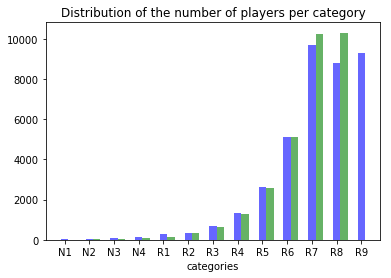

In [9]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

data1 = list(p_categories.values())
data2 = list(swt_categories.values())
width = 0.3
plt.bar(np.arange(len(data1)), data1, width=width, color='b', alpha=0.6)
plt.xticks(np.arange(len(data1)), list(p_categories.keys()))

plt.bar(np.arange(len(data2))+ width, data2, width=width, color='g', alpha=0.6)
plt.xlabel('categories')
plt.title('Distribution of the number of players per category')
plt.show()

Plot the differences of each category. As for R9 Swisstennis gives no indication. All the others are classified R9, so consider only the differences from N1-N4 and from R1-R8.


First start with the first national players:

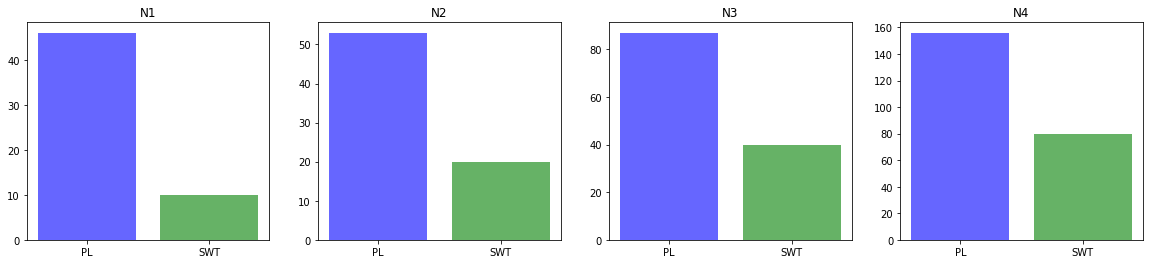

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
    
for i, ax in enumerate(axes): 
    pos = np.array([0, 1])
    values = [data1[i], data2[i]]
    objects = ['PL', 'SWT']
    ax.bar(pos, values, align='center', alpha=0.6, color=('b', 'g'))
    ax.set_xticks(pos)
    ax.set_xticklabels(objects)
    ax.set_title(list(swt_categories.keys())[i])           
plt.show()

Again in blue the number of the collected players in the dataset where the analysis in this notebook is based on and in green the numbers given by Swisstennis (SWT).

So for the N categories, there are more players in the dataset as it should be. So is the dataset erroneous ?
No, it is not. The reason is that the foreign players get a ranking as well and are assigned a unique number and a ranking category. So it is perfectly ok.

Do the same for the regional (R-) Players:

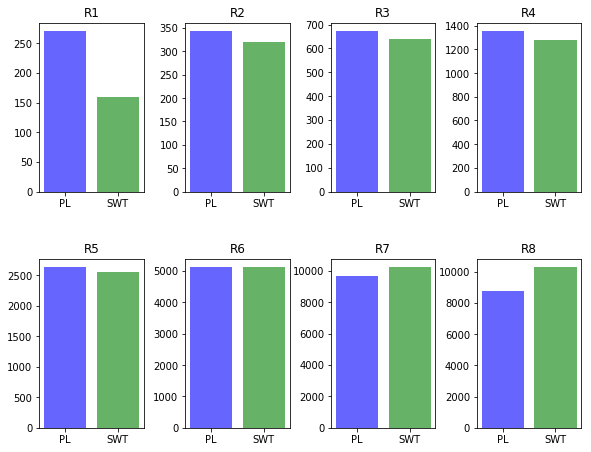

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(7, 3))
plt.subplots_adjust(left=None, bottom=None, right=1.2, top=2, wspace=0.4, hspace=0.4)
    
for i in range(4):
    j = i + 4
    pos = np.array([0, 1])
    values = [data1[j], data2[j]]
    objects = ['PL', 'SWT']
    axes[0,i].bar(pos, values, align='center', alpha=0.6, color=('b', 'g'))
    axes[0,i].set_xticks(pos)
    axes[0,i].set_xticklabels(objects)
    axes[0,i].set_title(list(swt_categories.keys())[j])   
    
for i in range(4):
    j = i + 8
    pos = np.array([0, 1])
    values = [data1[j], data2[j]]
    objects = ['PL', 'SWT']
    axes[1,i].bar(pos, values, align='center', alpha=0.6, color=('b', 'g'))
    axes[1,i].set_xticks(pos)
    axes[1,i].set_xticklabels(objects)
    axes[1,i].set_title(list(swt_categories.keys())[j]) 
plt.show()

For the first R categories we have the same phenomenon with the foreign players as with the national (N-) categories.
At the lower end of the ranking we obviously have some "holes". So it looks we are lacking some players. The question would need to be asked to Swisstennis. I have no clear explanation for this.
Nevertheless we have a lot of data present to do regression investigations.

Distribution by age category. The names of the categories are:
- A = active players between 18 and 35.
- 18&U: under 18
- 35+: senior category over 35.

In [12]:
categories = np.sort(data_p.age_category.unique())
a_categories = {}
p_groupedby_age = data_p.groupby('age_category')
for i in categories:
    df = p_groupedby_age.get_group(i)
    print('Number of ' + i + ': ', len(df))
    #print( len(df))
    a_categories[i] = len(df)

Number of 10&U:  1160
Number of 12&U:  1898
Number of 14&U:  2130
Number of 16&U:  1884
Number of 18&U:  1578
Number of 35+:  3107
Number of 40+:  3133
Number of 45+:  3278
Number of 50+:  3328
Number of 55+:  2769
Number of 60+:  2152
Number of 65+:  1775
Number of 70+:  1328
Number of 75+:  590
Number of 80+:  140
Number of A:  8254


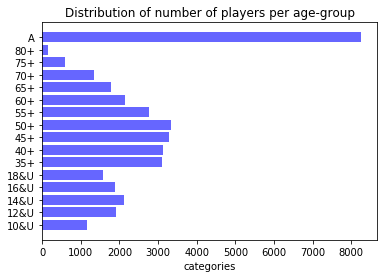

In [13]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

data = list(a_categories.values())

plt.barh(np.arange(16), data, color='b', alpha=0.6)
plt.yticks(np.arange(16), list(a_categories.keys()))
plt.xlabel('categories')
plt.title('Distribution of number of players per age-group')
plt.show()

In the overall ranking, each players has a number. Do we have holes ?

In [14]:
print('Ranking - From - To:   Missing Ranking Numbers ')
print('============================================')

# all the collected rankings in data_p
all_rankings = set(data_p.ranking_number.values)

range_low = 1
for i in swt_categories.keys():
    range_high = range_low + swt_categories[i] - 1
    
    # create the set for each category which contains the ranking number it should have
    swt_set_cat = set(np.arange(range_low ,range_high + 1,1 ))
    
    # lookup the "wholes"
    result = swt_set_cat.difference(all_rankings)
    print("%s %6d  to %6d:  %s" % (i, range_low, range_high, len(result)))
    
    range_low = range_high + 1


Ranking - From - To:   Missing Ranking Numbers 
N1      1  to     10:  2
N2     11  to     30:  0
N3     31  to     70:  0
N4     71  to    150:  0
R1    151  to    310:  0
R2    311  to    630:  2
R3    631  to   1270:  8
R4   1271  to   2550:  13
R5   2551  to   5110:  29
R6   5111  to  10230:  141
R7  10231  to  20470:  849
R8  20471  to  30770:  2207


In the N1 category there are two prominent missing players: Roger Federer and Stan Wawrinka. As they are not playing regular tournaments within Switzerland, their licence status is set to inactive (for Federer see: https://www.swisstennis.ch/user/1758/results-summary), but they still do the ranking calculation for the two players. Anyway: for the further calculation I will only consider players which played at least one match.

Distribution of the grading value: 

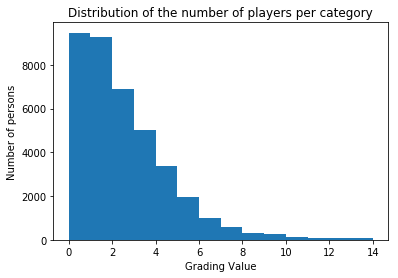

In [15]:
bins = list(range(15))
plt.xlabel('Grading Value')
plt.ylabel('Number of persons')
plt.title('Distribution of the number of players per category')
plt.hist(data_p.grading_value, bins);

So the best players have a grading value of over 14 and the weakest players are in [0,1]

### 2.3) Match data
The second input file is the matches file.

#### Data Cleaning

First do some data cleaning as removing the not used columns and for convenience sort the matches by date.

In [16]:
data_m = data_m.drop(['url','sets_won', 'sets_lost', 'ranking1', 'score_1'], axis=1)
data_m['date'] = pd.to_datetime(data_m['date'], errors='coerce')
data_m = data_m.sort_values(by='date')

For the further ranking calculation we have to drop the so called w.o matches (w.o = walk over, matches which were not played). As those matches did not take place, they are not taken into account for the calculation. 

In [17]:
# drop w.o matches row
data_m = data_m.dropna(subset=['victory'], axis ='index')
data_m = data_m.dropna(subset=['comp_value2'], axis ='index')
data_m = data_m.dropna(subset=['comp_value1'], axis ='index')


#### Insight of the data
Print some match statistics

Number of players who won at least one match:           25442
Number of players who lost at least one match:          29212
Number of players who had played at least one match:    31834
Number of players who have a (active) licence:          38504



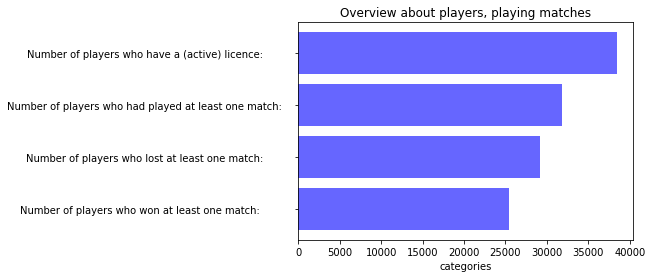

In [18]:
# drop woman matches #metoo
data_m['gender'] = data_m[['player1id', 'player2id']].apply(get_gender_of_match, axis=1)
data_m = data_m[data_m['gender'] == 1]

all_winning_players = data_m.player1id.unique()                      # all the player who won at least one match
all_winning_players = all_winning_players[all_winning_players > 0]   # remove the foreign results:
all_losing_players = data_m.player2id.unique()                       # all the players who lost at least one match
all_losing_players = all_losing_players[all_losing_players > 0       # remove the foreign results:
                                       ]
all_win_defeat_players = np.union1d(all_winning_players,all_losing_players) # union between the previous sets
all_players_with_match = all_win_defeat_players[all_win_defeat_players > 0]

text1 = "Number of players who won at least one match:          "
text2 = "Number of players who lost at least one match:         "
text3 = "Number of players who had played at least one match:   "
text4 = "Number of players who have a (active) licence:         "

print(text1, len(all_winning_players))
print(text2, len(all_losing_players))
print(text3, len(all_players_with_match))
print(text4, len(data_p.swisstennis_id.values))
print()

data = [len(all_winning_players), len(all_losing_players), len(all_players_with_match) ,len(data_p.swisstennis_id.values)]
plt.barh(np.arange(4), data, color='b', alpha=0.6)
plt.yticks(np.arange(4), [text1, text2, text3, text4])
plt.xlabel('categories')
plt.title('Overview about players, playing matches')
plt.show()

## 3) The goal and approach

Swisstennis determines twice a year the new rankings. The ranking is based on the grading value (GV) which is composed by the competition value (CV) and the risk award (RA). Swisstennis pretends that both are calculated according to the formula from above, which is not 100% true. I want to challenge if a better prediction is possible for CV, RA and the GV with machine learning techniques. The formulas will serve as a first baseline.

The approach is the following:
- create a feature matrix for every player which contains the competition values of all the opponents the player played against.
- discuss the formula for the competition value. Analyze the causes for improving the ranking and getting a better CV. What are the driving components ? How does the CV change when changing the input parameters ?
- do a first prediction of the new CV with a neural network, a ridge regression and a random forest regressor.
- do additional feature engineering, analyze the impact of the newly created features. What happens if features are removed ?
- analyze the input as well as the output data
- evaluate the best model

The same at the end with the risk award and the final grading value. Not the same deep analysis is done for the risk award and the grading value, as both rely also on the matches and the underlying CV.

Before starting with the analysis I have to outline a restriction of the dataset: Swisstennis claims to process the formulas on the competition values several times to calculate the next ranking. As I took the data from october in one shot, I could only get the previous competition value of the last run. I tried the get from Swisstennis the data from the first run, but unfortunately I did not get an answer.

For a first feature engineering: all the victories and defeats will be aligned in different columns. The columns for the winning matches will be "W0", "W1", ... for the lost matches it will be "L0", "L1", ..... If a value is 0 that means the is neither a victory nor a defeat, this simply means there was no match played.

The Swisstennis data should be correct in a sense, if people notice a difference , Swisstennis is immediately informed to correct the result. Also I want to do predictions for all kind of players. So I won't look for any outliers in the input data.

### Supportive Functions

Following are some helper functions to be used to construct the feature data-set and to start from scratch.

In [19]:
# display matches of a player
def display_matches(p_id):
    df1 = data_m[data_m.player1id == p_id]
    df2 = data_m[data_m.player2id == p_id]
    return pd.concat([df1,df2])

   

After having loaded the matches and players csv data, some clean-up needs to be done

In [20]:
def preparation():
    global data_m, data_p, swt_id_woman
    
    # from the licence number get the gender of the player
    data_p['gender'] = data_p['licence_number'].apply(get_gender)
    
    # this function helps to verify if it is a "ladies" or "men" match, i will only consider men matches
    df = data_p[data_p['gender'] == 2]
    swt_id_woman = set(df['swisstennis_id'].values.tolist())
    
    # erase unused data
    data_m = data_m.drop(['url','sets_won', 'sets_lost', 'ranking1', 'score_1'], axis=1)
    data_m['date'] = pd.to_datetime(data_m['date'], errors='coerce')
    
    # sort for better visibilty
    data_m = data_m.sort_values(by='date')

    ## DATA CLEANING
    # drop w.o matches row
    data_m = data_m.dropna(subset=['victory'], axis ='index')
    data_m = data_m.dropna(subset=['comp_value2'], axis ='index')
    data_m = data_m.dropna(subset=['comp_value1'], axis ='index')
    data_m.head(2)

    # drop woman matches
    data_m['gender'] = data_m[['player1id', 'player2id']].apply(get_gender_of_match, axis=1)
    data_p = data_p[data_p['gender'] == 1]
    data_m = data_m[data_m['gender'] == 1]
    

The next functionalites initializes some global variables. All dictionary tables for fast access to build the "data" feature matrix

In [21]:
def init_global_vars():
    global player_dict_previous_cv, player_dict_current_cv, player_dict_name, player_dict_risk_award, player_dict_ranking 
    
    # create a player dictionary (swisstennis_id, previous competition_value ) for fast access
    player_dict_previous_cv = {}
    
    # create a player dictionary (swisstennis_id, current competition_value ) for fast access
    player_dict_current_cv = {}

    # create a player dictionary (swisstennis_id, Name)
    player_dict_name = {}

    # create a player dictionary (swisstennis_id, risk award ) for fast access
    player_dict_risk_award = {}

    # create a player dictionary (swisstennis_id, ranking)
    player_dict_ranking = {}
    
    for index, row in data_m.iterrows():
        player_dict_previous_cv[row['player1id']] = round(row['comp_value1'], 3)
        player_dict_previous_cv[row['player2id']] = round(row['comp_value2'], 3)
        
    for index, row in data_p.iterrows():
        player_dict_current_cv[row['swisstennis_id']] = round(row['comp_value'], 3)
        player_dict_name[row['swisstennis_id']] = row['first_name'] + ' ' + row['last_name']
        player_dict_risk_award[row['swisstennis_id']] = round(row['grading_value'] - row['comp_value'], 3) 
        player_dict_ranking[row['swisstennis_id']] =  row['ranking']
        
    global all_winning_players, all_losing_players, all_win_defeat_players, all_players_with_match
    
    all_winning_players = data_m.player1id.unique()                       # all the player who won at least one match
    all_winning_players = all_winning_players[all_winning_players > 0]    # remove the foreign results
    all_losing_players = data_m.player2id.unique()                        # all the players who lost at least one match
    all_losing_players = all_losing_players[all_losing_players > 0]       # remove the foreign results
                                            
    all_win_defeat_players = np.union1d(all_winning_players, all_losing_players) # union between the previous sets, just temp. usage 
    all_players_with_match = all_win_defeat_players[all_win_defeat_players > 0]    

Consistence check: verifies if all entries in the match frame have a corresponding entry in the players dataframe. This is ok now, initially there were missing players and the java runner had to be run again.

In [22]:
def consistence_check():    
    # helper dictionary
    player_dict = {}
    for index, row in data_p.iterrows():
        player_dict[row['swisstennis_id']] = row['first_name'] + ' ' + row['last_name']

    # this is the consistence check
    counter = 0
    missing_list = []
    for index, row in data_m.iterrows():
        p1_id = row['player1id']
        p2_id = row['player2id']
        if p1_id > 0:
            if not (p1_id in player_dict):
                print('id missing:', p1_id, row['player1name'])
                missing_list.append(p1_id)
                counter = counter + 1
        if p2_id > 0:
            if not (p2_id in player_dict):
                print('id missing:', p2_id, row['player2name'])
                missing_list.append(p2_id)
                counter = counter + 1  
    print('number of id missing:', counter)

Calculate the values of the competition value with the swisstennis formula:

In [23]:
import math 
# calculates the official result (CV) using the swisstennis formula
def calculate_comp_result(win_arr, lost_arr):
    win_arr = win_arr[win_arr > 0]
    lost_arr = lost_arr[lost_arr > 0]
    # to keep the outliers
    if (len(win_arr) == 0):
        win_arr = np.array([0])
   
    win_sum =  np.log(sum([math.exp(x) for x in win_arr]))
    lost_sum = np.log(sum([math.exp(-x) for x in lost_arr]))
                      
    return (win_sum - lost_sum) / 2

Calculate the values of the risk award with the swisstennis formula:

In [24]:
# calculates the official result (RA) using the swisstennis formula
def calculate_risk_award(win_arr, lost_arr):
    win_arr = win_arr[win_arr > 0]
    lost_arr = lost_arr[lost_arr > 0]
    # to keep the outliers
    if (len(win_arr) == 0):
        win_arr = np.array([0])
    
    win_sum =  np.log(sum([math.exp(x) for x in win_arr]))
    lost_sum = np.log(sum([math.exp(-x) for x in lost_arr]))
                      
    return (win_sum + lost_sum) / 6    

After every 6th played match, each player can erase one defeat, always the defeat against the weakest player is taken. This is accomplished with the following function.

In [25]:
# results to erase
def results_to_erase(win_row, def_row):
    nbr_of_matches = len(win_row[win_row > 0]) + len(def_row[def_row > 0]) - 2 # remove two, the own matches
    defeats_to_erase = nbr_of_matches // 6

    defeats_to_erase = min(defeats_to_erase, len(def_row[def_row > 0]) - 1)     # maximum to erase
    # there are some strange constellations, where a players comp_value is 0, so do some adustements

    if defeats_to_erase < 0:
        defeats_to_erase = 0
        print('outlier1')
        return def_row

    # the first value in the row is the own comp_value, leave as it is
    a = np.copy(def_row[def_row > 0])
    own_comp_value = a[0]

    # the exception cases
    if len(a) == 0:
        return def_row
        print('outlier2')

    own_comp_value = a[0]
    a = a[1:len(a)]
    a.sort()

    # delete the matches
    for i in range(defeats_to_erase):
        a = np.delete(a, 0)
    
    # reconstruct def_row
    def_row = np.append(np.array([own_comp_value]), a)
    def_row = np.append(def_row, np.zeros(nbr_of_columns - len(def_row)))

    return def_row
    

In [26]:
# returns all columns starting with 'W' or 'L' (helper function)
def get_W_or_L_columns(df):
    col = []
    for i in df.columns:
        if (i.startswith('W') or i.startswith('L')): 
            col.append(i)
    return col

This function wraps the train_test_split function. It does some data cleaning and removes the necessary columns. 

In [27]:
# wraps the train-test splitting procedure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# wrapped the train and test split, if a parameter is given this will be the labeled column
def splitdata_train_test(df, *args):
    if len(args) != 0:
        label_col = args[0]
    else:
        label_col = 'CV_C'  # default column
    
    # work on a copy
    df = df.copy()
    
    # indexing with the swisstennis-id
    df['Id'] = df['Id'].apply(pd.to_numeric)
    df.set_index('Id', inplace = True)
    
    col_win_or_lost = get_W_or_L_columns(df)
    
    # the columns which are at the head
    columns_head = np.setdiff1d(np.array(df.columns) , np.array(col_win_or_lost + ['CV_PrevW', 'CV_PrevL']))
    
    # create train and test sets, set the random_state in order to get the same results
    X_tr, X_te, y_tr, y_te = train_test_split(
        df.drop(columns_head , axis = 1),
        df[label_col],
        test_size=4000, random_state=0
    )
    return X_tr, X_te, y_tr, y_te
    

In [28]:
# my MAE calculations
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [29]:
# returns the whole test set
def get_whole_set(df, X_te):
    df = df.copy()
    df['Id'] = df['Id'].apply(pd.to_numeric)
    df.set_index('Id', inplace = True)
    df = df.loc[X_te.index]
    return df

The next cell does the whole calculation. For each player it creates one row with the competition values of the lost and won matches. This is the main feature matrix

In [30]:
# execution time:  around 1 - 2 minutes
def create_data():
    global nbr_of_columns
    # nbr_of_columns = 77
    nbr_of_columns = 82

    # data structure to help do build the "data" dataframe
    data_m_win = data_m.copy()
    data_m_defeat = data_m.copy()
    data_m_win.set_index('player1id', inplace=True)
    data_m_defeat.set_index('player2id', inplace=True)

    rows = []
    counter = 0
    for i in all_players_with_match:
        # get all the won matches
        win_row = np.zeros(nbr_of_columns)
        # set the previous competition value of the this player as first item of the list
        win_row[0] = player_dict_previous_cv[i]
        # also collect the opponenent-ids
        win_opp_row = np.zeros(nbr_of_columns)

        # check if the player has won matches
        if (i in data_m_win.index):
            df = data_m_win.loc[i]
            comp_values = df['comp_value2']
            opponent_ids = df['player2id']

            # can be either of series or just numpy.float, check it
            # because of the clumsy implementation of pd: does return other datatypes depending of the number of results !!!
            if isinstance(comp_values, pd.Series):
                win_values = comp_values.values
                win_opp_ids = opponent_ids.values
            else:
                win_values = np.array([comp_values])
                win_opp_ids =  np.array([opponent_ids])

            win_row[1:1+len(win_values)] = win_values
            win_opp_row[0:len(win_opp_ids)] = win_opp_ids

        # the same calculation with the lost matches
        # get all the lost matches
        def_row = np.zeros(nbr_of_columns)
        def_row[0] = player_dict_previous_cv[i]
         # also collect the opponenent-ids
        def_opp_row = np.zeros(nbr_of_columns)

        # check if the player has lost matches
        if (i in data_m_defeat.index):
            df = data_m_defeat.loc[i]
            comp_values = df['comp_value1']
            opponent_ids = df['player1id']

            # can be either of series or just numpy.float, check it
            if isinstance(comp_values, pd.Series):
                def_values = comp_values.values
                def_opp_ids = opponent_ids.values
            else:
                def_values = np.array([comp_values])
                def_opp_ids = np.array([opponent_ids])

            def_row[1:1+len(def_values)] = def_values
            def_opp_row[0:len(def_opp_ids)] = def_opp_ids

        # the current competition value of the player and risk award of the player
        cv_current = np.array([player_dict_current_cv[i]])
        risk_award = np.array([player_dict_risk_award[i]]) 
        grading_value = cv_current + risk_award


        # add some meta information to the frame: swisstennis_id, name (just for displaying purposes)
        info = np.array([i, player_dict_name[i]])

        # do exact rounding
        win_row = np.around(win_row, decimals=3)
        def_row = np.around(def_row, decimals=3)

        # convert to int
        win_opp_row = win_opp_row.astype(int)
        def_opp_row = def_opp_row.astype(int)

        # erase the lost matches (every 6th match)
        def_row = results_to_erase(win_row, def_row)

        # calculated competition result, calculated according to the swisstennis formula
        calc_comp_result = np.round(calculate_comp_result(win_row, def_row), decimals=3)
        calc_risk_award  = np.round(calculate_risk_award(win_row, def_row), decimals=3)


        row = np.concatenate((info, np.array([grading_value, calc_risk_award, risk_award , calc_comp_result]), cv_current, win_row, def_row, win_opp_row, def_opp_row))

        rows.append(row)

        counter = counter + 1
        if counter % 5000 == 0:
            print('# of processed players:', counter)

    col_win = ['CV_PrevW'] + ['W'+ str(x) for x in list(range(nbr_of_columns -1))]
    col_lost = ['CV_PrevL']  + ['L'+ str(x) for x in list(range(nbr_of_columns -1))]
    col_c = ['Id', 'Name', 'GV', 'RA_CA', 'RA_C', 'CV_CA', 'CV_C']
    col_win_opp = ['W_opp'+ str(x) for x in list(range(nbr_of_columns))]
    col_def_opp = ['L_opp'+ str(x) for x in list(range(nbr_of_columns))]

    columns = col_c + col_win + col_lost + col_win_opp + col_def_opp

    data =  pd.DataFrame(rows, columns=columns)

    # set the type to float for the columns, expect the columns Id and Name
    data = pd.concat([data[['Id', 'Name']], data[['GV','RA_CA', 'RA_C', 'CV_CA', 'CV_C'] + col_win + col_lost].astype(float), data[col_win_opp + col_def_opp].astype(int)], sort=False, axis = 1)

    data_original = data.copy()

    # remove the opponent-ids as they are not needed at the beginning
    col = []
    for i in data.columns:
        if (i.startswith('W_opp') or i.startswith('L_opp')): 
                col.append(i)

    data = data.drop(col, axis = 1)
   
    return data, data_original
    

## 4) Data preparation

Let us start from scratch and execute the following tasks:
- read the data from the two files for the periode of 2-2019:
- do some data cleaning and initialize some global variables to be used later to construct the dataframe

In [31]:
# read the player and matches data
data_p = pd.read_csv('04_data/players-2-2019.csv')
data_m = pd.read_csv('04_data/matches-2-2019.csv', encoding = "utf-8")

print('Matches shape:', data_m.shape)
preparation()
print('Matches shape after cleaning and first processing:', data_m.shape)

# initializes some global variables to be used later
init_global_vars()

# does a consistence check, each entry in data_m must have have one entry in data_p. That means, each match can be associated to a player.
consistence_check()

Matches shape: (172656, 15)
Matches shape after cleaning and first processing: (124018, 11)
number of id missing: 0


In [32]:
data_p.head()

,id,comp_value,current_periode,first_name,grading_value,last_name,last_updated_at,licence_number,member_ship,previous_ranking,previous_ranking_number,ranking,ranking_number,swisstennis_id,age_category,licence_status,gender
1,2,0.750,2/2019,Sébastien,0.750,Reuge,2019-12-20 14:40:31.0,737.83.239.0,Lancy-Fraisiers,R9,31800,R9,33575,131078,35+,suspendiert,1
2,3,0.750,2/2019,Marco,0.750,Bärtsch,2019-12-20 14:40:31.0,139.85.156.0,Pizol,R8,27344,R9,33575,131076,A,suspendiert,1
3,4,0.750,2/2019,Valerio,0.750,Lanfranchi,2019-12-20 14:40:31.0,577.04.156.0,Zizers,R9,31800,R9,33575,131083,16&U,suspendiert,1
4,5,0.750,2/2019,Jarvin,0.750,Zemp,2019-12-20 14:40:31.0,983.07.459.0,Buttisholz,R8,26823,R9,33575,131080,12&U,aktiv,1
5,6,0.705,2/2019,Tobias,0.803,Krummenacher,2019-12-20 14:40:31.0,564.08.126.0,Buttisholz,R9,41772,R9,32953,131081,12&U,aktiv,1


As the number of id's missing is 0, we can proceed (consistence_check()).  The next processing will create the first version of the feature matrix. The feature matrix will create exactly one entry for each player and align all his results in one row. Details are given on a sample below:

In [33]:
# create the feature matrix: this is the main data processing
data, data_original = create_data()

# take a backup for future usage
data_copy = data.copy()

# display the most important columns
data[['Id','Name', 'GV', 'RA_CA', 'RA_C' ,'CV_CA', 'CV_C', 'CV_PrevW', 'W0', 'W1', 'W2', 'W3', 'W4', 
          'W5', 'W6', 'CV_PrevL', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6']].head()

# of processed players: 5000
# of processed players: 10000
# of processed players: 15000
# of processed players: 20000
# of processed players: 25000
# of processed players: 30000


,Id,Name,GV,RA_CA,RA_C,CV_CA,CV_C,CV_PrevW,W0,W1,...,W5,W6,CV_PrevL,L0,L1,L2,L3,L4,L5,L6
0,1520,Heinrich Schaerer,2.635,0.219,0.243,2.621,2.392,2.383,2.427,1.465,...,0.000,0.000,2.383,3.038,0.0,0.0,0.0,0.0,0.0,0.0
1,1525,René Gut,7.061,0.213,0.356,7.305,6.705,6.666,2.545,4.523,...,2.881,3.813,6.666,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2,1530,Andreas Fischer,4.579,0.454,0.562,4.463,4.017,3.971,2.068,3.614,...,3.902,3.363,3.971,3.644,0.0,0.0,0.0,0.0,0.0,0.0
3,1531,Andreas Fischer,5.422,0.356,0.604,5.679,4.818,4.767,4.200,2.990,...,4.387,3.199,4.767,6.536,0.0,0.0,0.0,0.0,0.0,0.0
4,1536,Gian-Andrea Fischer,5.025,0.269,0.467,5.312,4.558,4.504,1.459,5.728,...,2.594,0.000,4.504,0.000,0.0,0.0,0.0,0.0,0.0,0.0


**Explanation:** of the columns: 
- Id: Swisstennis_id, primary key
- Name: Name of the player
- GV: this is the current Grading value
- RA_CA: risk award, calculated (_CA) according to the formula above. This is the baseline for the risk ward (RA) value.
- RA_C: the current risk award
- CV_C: the current competition value
- CV_CA: competition value, calculated (_CA) according to the formula above. This is the baseline for the competition value (CV).
- CV_PrevW: this is the previous competition value of the concerned player. This will be used for the winning calculation.
- WO ... W82: these are the columns of competition value of the won matches.
- CV_PrevL: this is the previous competition value again of the concerned player. This will be used for the defeat calculation. Is exactly the same value as CV_prevW.
- LO ... L82: these are the columns of competition value of the lost matches.

let's us take the first row with the Id=1510: 

Heinrich Schaerer has a GV (grading value) since october 2019 of 2.635, a competition value since 2019-10 (october) of 2.392 and in the previous ranking periode he had a competition value of 2.383. The risk award is not given here but can easly be calculated by GV - CV_C.

The baseline which is the competition value calculated by the swisstennis formula is CV_CA = 2.621. For the risk award it is: 0.219.

During the periode from 1.10.2018 till 30.9.2019 Heinrich Schaerer won two matches against players which had a comp-value of 2.427 and 1.465 during that time and he lost one match against a player with the comp-value of 3.038. For every pack of 6 matches, the worst negative result is erased from the "defeat" list. In this feature matrix above, those matches were already removed. Heinrich Schaerer only played 3 matches and got no "erasing" result. This entry can be compared by taking the Id and calling the Swisstennis page. For this sample it is: 
https://www.swisstennis.ch/user/1520/results-summary





## 5) First Analysis for the competition value (CV)
I chose the following algorithms for regression problems:
- ridge regression with polynomial features. Multiple regression is probably the most obvious model for regression problems, so this is certainly the first choice. As the formula indicates exp and ln-terms, I added polynomial features.
- neural networks: even if those models are probably not the first choice for regression models, I wanted to try it out (personal interest).
- random forest: I got the hint that RF gives better predictions than k-NN.

So now we got the feature matrix, we can do a first analysis. The competition value (CV) is the most important value and is the only value the Swisstennis formula operates on. We first start trying to do better predictions for this value, than the baseline (=formula) does.

Do a first analysis without any further feature engineering.

`Prepare and split the data into training, test and validation sets.` The test-size is 4000. In the functions below the training set will then be split into a training and validation set.

In [34]:
X_train, X_test, y_train, y_test = splitdata_train_test(data)
print('Training shape: ', X_train.shape)
print('Testing shape: ', X_test.shape)

Training shape:  (27834, 164)
Testing shape:  (4000, 164)


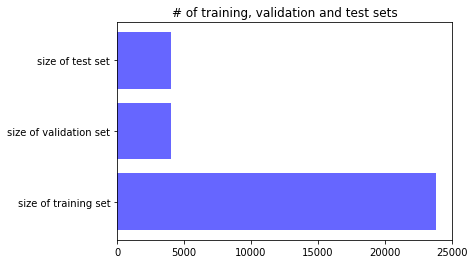

In [35]:
df = [len(y_train) - 4000, 4000, len(y_test),]
plt.barh(np.arange(3), df, color='b', alpha=0.6)
plt.yticks(np.arange(3), ['size of training set','size of validation set','size of test set'])
plt.title('# of training, validation and test sets')
plt.show()

y_CV_CA (y-Competition Value Calculated with the official Swisstennis formula. This will be the **baseline** for the competition value.

In [36]:
y_CV_CA = get_whole_set(data, X_test)['CV_CA']
y_CV_CA.shape

(4000,)

In [37]:
data.head()

,Id,Name,GV,RA_CA,RA_C,CV_CA,CV_C,CV_PrevW,W0,W1,...,L71,L72,L73,L74,L75,L76,L77,L78,L79,L80
0,1520,Heinrich Schaerer,2.635,0.219,0.243,2.621,2.392,2.383,2.427,1.465,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1525,René Gut,7.061,0.213,0.356,7.305,6.705,6.666,2.545,4.523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1530,Andreas Fischer,4.579,0.454,0.562,4.463,4.017,3.971,2.068,3.614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1531,Andreas Fischer,5.422,0.356,0.604,5.679,4.818,4.767,4.200,2.990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1536,Gian-Andrea Fischer,5.025,0.269,0.467,5.312,4.558,4.504,1.459,5.728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5.1) Neural Network
The neural network processing is implemented in a function. It does the necessary data preparation using the MinMax scaling. 

Different architectures with more dense layers and more neurons were tried, but none of them were better than the used construction below. 
I also tried to use drop-out and Regularization, but none of them improved the result. 

Early stopping is used to prevent over-fitting. As it is a regression task the output layer just has one output neuron which returns the predicted value. Gradient descent is being used to minimize the error in backpropagation. 20% of the data is used for validation and shuffled again after each run (epoch).

To compare the results the **MAE** (medium absolute error) is applied on all models. The loss function is based on the **MSE** (mean squared error). The reasons why MSE is used for loss are:
- according to the machine learning literature, MSE is the default loss for regression problems
- MSE is a "smooth" curve and gives better results. The below function can easily be changed by using the MAE as loss function, but the training and validation curve "jump around" and a less accurate value is achieved.

In [37]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import initializers
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l1

# implement neural network as a function to do further testing with different datasets
# if verbose is set to True the output from the keras processing is displayed
# if displayPlot is seto to True, the training curves are displayed
# args is an optional parameter to increase the number of epochs
def do_neural_network(X_tr, X_te, y_tr, y_te, verbose, batch_size, displayPlot, *args):
    scaler = MinMaxScaler()
    
    # split the training set in training and validation set, set the random state so we test the same for all classifiers
    X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=4000, random_state=0)
    
    X_tr_normed = scaler.fit_transform(X_tr)
    X_val_normed = scaler.transform(X_val)
    X_te_normed = scaler.transform(X_te)
    
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[X_tr_normed.shape[1]], 
                 kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)),
        layers.Dense(64, activation='relu', kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0)),
        layers.Dense(1)])

    model.compile(loss='mse', optimizer='sgd', metrics=['mae', 'mse'])
    
    # functionality to override the EPOCHS, it was mainly used in the testing phase
    if len(args) != 0:
        EPOCHS = args[0]
    else:
        EPOCHS = 500

    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

    history = model.fit(X_tr_normed, y_tr, 
                    epochs=EPOCHS, validation_data = (X_val_normed, y_val), verbose = verbose, shuffle=True, batch_size=batch_size,callbacks=[early_stop])
    
    loss, mae, mse = model.evaluate(X_te_normed, y_te, verbose=1)
    test_predictions = model.predict(X_te_normed).flatten()
    
    if displayPlot:
        # Create two plots: one for the loss value, one for the MAE
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

        # Plot accuracy values
        ax1.plot(history.history['loss'][5:], label='train loss')
        ax1.plot(history.history['val_loss'][5:], label='val loss')
        ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
            np.mean(history.history['val_loss'][-3:]) # last three values
        ))
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss value')
        ax1.legend()

        ax2.plot(history.history['mean_absolute_error'][5:], label='train mae')
        ax2.plot(history.history['val_mean_absolute_error'][5:], label='val mae')
        ax2.set_title('Validation mae {:.3f} (mean last 3)'.format(
            np.mean(history.history['val_mean_absolute_error'][-3:]) # last three values
        ))
        ax2.set_xlabel('epoch')
        ax2.legend()

        plt.show()
    
    
    return mae, test_predictions, model

Do the training of the neural network. It you want to get the detailed result, set the verbose parameter to 1 which prints the keras results after each epoch.
batch_size is set to 32 which is very low. The reason for this low value is to be able to show the gradient descent training plot below. For sure bigger batchsizes are faster, but I liked the plot below. And as the datasize is not that big and there are not so many parameters to be trained, the time for training is still reasonable.

4000/4000 [==============================] - 0s 11us/step


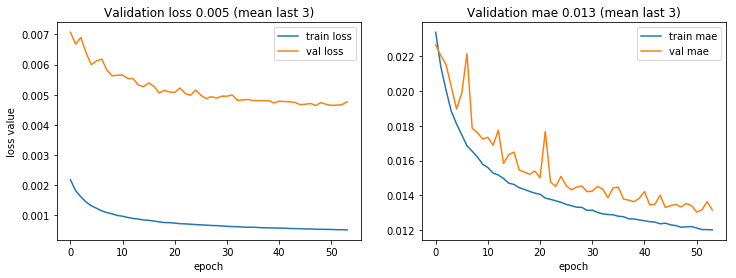

Testing set mean absolute error for a neural network: 0.014 


In [38]:
mae_nn1, test_predictions, _ = do_neural_network(X_train, X_test, y_train, y_test, 0, 32, True)
print("Testing set mean absolute error for a neural network: {:5.3f} ".format(mae_nn1))

In [39]:
mae_baseline = MAE(y_CV_CA, y_test)
print("Testing set mean absolute error for the baseline: {:.3f} ".format(mae_baseline))

Testing set mean absolute error for the baseline: 0.250 


**Observation**: Regarding at those two plots the results are improved after each epoch. Although the epoch parameter was set to 500, the model did not improve after a while and the neural network stopped training to prevent overfitting (due to early stopping parameter). The result of this first regression is much better than the baseline.

### 5.2) Ridge Regression

As a next try, ridge regression is used. The whole computing is again wrapped in a function, as it will be used for not only for the competition value but also for risk award (RA) and the general grading value (GV) and with different features. Gridsearch to find the best alpha parameter.

In [40]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

def get_best_alpha(display_plot, X_tr_rescaled, X_val_rescaled, y_tr, y_val):
    # variable to store the results
    gs_results = []

    # grid search
    for alpha in np.logspace(-3, 3, num=20):
        # create and fit ridge regression
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_tr_rescaled, y_tr)

        # save model and its performance on train/test sets
        gs_results.append({
            'model': ridge,
            'alpha': alpha,
            'train_mse': MSE(10**y_tr - 1 , 10**ridge.predict(X_tr_rescaled) - 1),
            'train_mae': MAE(10**y_tr - 1, 10**ridge.predict(X_tr_rescaled) - 1),
            'val_mse': MSE(10**y_val - 1, 10**ridge.predict(X_val_rescaled) - 1),
            'val_mae': MAE(10**y_val -1 , 10**ridge.predict(X_val_rescaled) -1),
        })

    # convert results to DataFrame
    gs_results = pd.DataFrame(gs_results)
    
    best_result = gs_results.loc[gs_results.val_mse.idxmin()]
    
    if display_plot:
        # plot the validation curves
        plt.plot(np.log10(gs_results['alpha']), gs_results['train_mse'], label='train curve')
        plt.plot(np.log10(gs_results['alpha']), gs_results['val_mse'], label='validation curve')
       
        plt.title('Best alpha: {:.3f} - mse: {:.7f} mae: {:,.4f}'.format(
            best_result.alpha, best_result.val_mse, best_result.val_mae))
        
        # Mark best alpha value
        plt.scatter(np.log10(best_result.alpha), best_result.val_mse, marker='x', c='red', zorder=10)

        plt.xlabel('$log_{10}(alpha)$')
        plt.ylabel('MSE')
        plt.legend()
        plt.show()
    
    return best_result.alpha
    

# preprocessing function
def preprocess(df, col, min):
    # do a copy first
    df = df.copy()
    
    # apply log-transform as certain features could be skewed
    if min >= 0:
        df[col] = np.log10(df[col] + 1)   # usual log10 + 1 transform
    else:
        df[col] = np.log10(df[col] + (min * -1) + 1)  # get every value positive
    
    # add polynomial features
    for c in col:
        for d in [ 2, 3]:
            name = '{}**{}'.format(c, d)
            df[name] = df[c]**d
        
    return df

# implement the ridge regression as a function to do further testing with different datasets
def do_ridge_regression(X_tr, X_te, y_tr, y_te, display_plot):
    # the values of the given arguments could be negative, so evaluate the minimum
    # this is necessary for the log in preprocess step
    min = int(pd.concat([X_tr, X_te]).min().min()) 
    
    # split the training set in training and validation set, set the random state so we test the same for all classifiers
    X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=4000, random_state=0)
    
    # preprocess and add polynomial features
    X_tr = preprocess(X_tr, X_tr.columns, min)
    X_te = preprocess(X_te, X_te.columns, min)
    X_val = preprocess(X_val, X_val.columns, min)
    
    # log transform as variable could be skewed
    y_tr = np.log10(y_tr + 1)
    y_te = np.log10(y_te + 1)
    y_val = np.log10(y_val + 1)
    
    # standardize features
    scaler = MinMaxScaler()
    X_tr_rescaled = scaler.fit_transform(X_tr)
    X_te_rescaled = scaler.transform(X_te)
    X_val_rescaled = scaler.transform(X_val)
        
    # get best alpha
    alpha = get_best_alpha(display_plot, X_tr_rescaled, X_val_rescaled, y_tr, y_val)
    
    # do ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_tr_rescaled, y_tr)
    print('best alpha: {:.3f}'.format(alpha))
    
    # test on the test set
    ridge_mse = MSE(y_te, ridge.predict(X_te_rescaled)-1)
    ridge_mae = MAE(10**y_te - 1, 10**ridge.predict(X_te_rescaled) - 1)
    
    return ridge_mse, ridge_mae, 10**ridge.predict(X_te_rescaled) - 1 

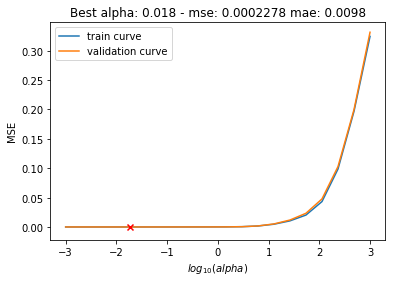

best alpha: 0.018
MAE for ridge regression: 0.0097067 


In [41]:
# process the data with ridge regression
_, mae_ridge1, test_predictions = do_ridge_regression(X_train, X_test, y_train, y_test, True)
print('MAE for ridge regression: {:.7f} '.format(mae_ridge1))

**Observation:** The ridge regressor finds very quickly the best alpha value. Train and valdiation curve are almost identical. The **MAE** is even better than with the neural network.

### 5.3) Random Forest

Random Forest is the last regression technique to be used. Next follows a function to find the hypervalue "number of estimators".

In [42]:
# evalutes the best number of estimators and if displayPlot is set to True, plots the validation curve
def get_best_nbr_of_estimators(arg_range, X_tr, X_val, y_tr, y_val, display_plot):
    # variable to store the results
    gs_results = []

    # gridsearch
    for i in arg_range:
        # create and fit random forest regressor
        regressor = RandomForestRegressor(n_estimators=i, random_state = 0)
        regressor.fit(X_tr, y_tr)

        # Save model and its performance on train/test sets
        gs_results.append({
            'model': regressor,
            'n_estimators': i,
            'train_mse': MSE(y_tr, regressor.predict(X_tr)),
            'train_mae': MAE(y_tr, regressor.predict(X_tr)),
            'val_mse': MSE(y_val, regressor.predict(X_val)),
            'val_mae': MAE(y_val, regressor.predict(X_val)),
        })

    # convert results to DataFrame
    gs_results = pd.DataFrame(gs_results)
    
    best_result = gs_results.loc[gs_results.val_mse.idxmin()]
    
    if display_plot:
        # plot the validation curves
        plt.plot(gs_results['n_estimators'], gs_results['train_mse'], label='train curve')
        plt.plot(gs_results['n_estimators'], gs_results['val_mse'], label='test curve')
       
        plt.title('Training and Validation MSE plots Random Forest')

        plt.xlabel('Number of estimators')
        plt.ylabel('MSE')
        plt.legend()
        plt.show()
    
    return best_result.n_estimators, gs_results

In [43]:
from sklearn.ensemble import RandomForestRegressor

# implement the ridge regression as a function to do further testing with different datasets
def do_random_forest(X_tr, X_te, y_tr, y_te, display_plot, argument):
    # no scaling needed for random forest, see also: https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package
    
    # split the training set in training and validation set, set the random state so we test the same for all classifiers
    X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=4000, random_state=0)
    
    
    # if the number of estimators is given as an optional parameter, do not try to evaluate it with the best_estimator function
    if isinstance(argument, range):
        n_estimators, _ = get_best_nbr_of_estimators(argument, X_tr, X_val , y_tr, y_val, display_plot)
        print('best number of estimators', n_estimators)
    else:
        n_estimators = argument

    # do again the fit with the best number of estimators
    regressor = RandomForestRegressor(n_estimators = n_estimators, random_state = 0)
    regressor.fit(X_tr, y_tr)
    
    test_predictions = regressor.predict(X_te)
    mae_rf = MAE(test_predictions, y_te)
    return mae_rf, regressor

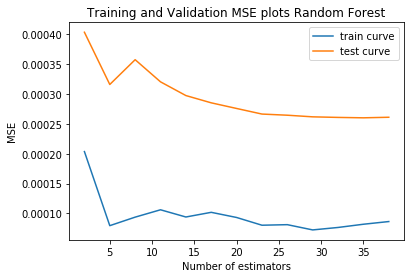

best number of estimators 35
MAE for random forest comp-value: 0.0102026


In [44]:
mae_rf, _ = do_random_forest(X_train , X_test, y_train, y_test, True, range(2, 40, 3))
print('MAE for random forest comp-value: {:.7f}'.format(mae_rf))

**Observation:** It looks that the results are getting better when inscreasing the number of estimators. When playing around with the range parameter the validation result decreases as the number of estimators increases, but the increase is tiny. As the processing lasts very long it is not done here.
So do again a random forest regression without gridsearching the best number of estimators (as this would last very long), but just by giving as a parameter the number of estimatores = 200.

In [45]:
mae_rf, _ = do_random_forest(X_train , X_test, y_train, y_test, True, 200)
print('MAE for random forest comp-value: {:.7f}'.format(mae_rf))

MAE for random forest comp-value: 0.0100718


### 5.4) First Summary

All the predictions with the neural network, ridge regression or random forest are much better than the baseline.
Visualize the results.

In [46]:
# plots the dataframe as bar chart
def plot_bar(df, title, *args):
    objects = df.Method
    y_pos = np.arange(len(objects))
    performance = df['MAE']

    plt.barh(y_pos, performance, align='edge', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('MAE')
    plt.title(title)
    if len(args) != 0:
        plt.xlim(args[0])
    
    plt.show()    

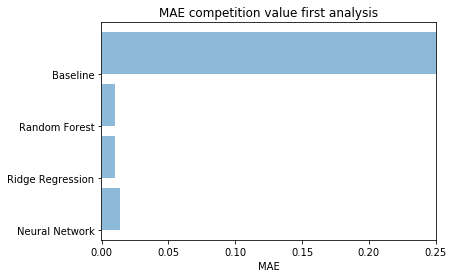

,Method,MAE
0,Neural Network,0.013625
1,Ridge Regression,0.009707
2,Random Forest,0.010072
3,Baseline,0.250425


In [47]:
# display all the data
d = {'Method': ['Neural Network', 'Ridge Regression', 'Random Forest', 'Baseline'], 'MAE': [mae_nn1, mae_ridge1, mae_rf, mae_baseline]}
df = pd.DataFrame.from_dict(d)
plot_bar(df, 'MAE competition value first analysis', (min(df.MAE) - 0.01, max(df.MAE)))
df

The same without baseline for better visibility:

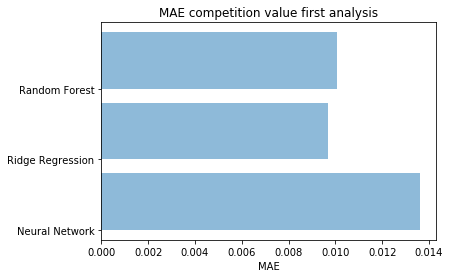

In [48]:
d = {'Method': ['Neural Network', 'Ridge Regression', 'Random Forest'], 'MAE': [mae_nn1, mae_ridge1, mae_rf]}
df = pd.DataFrame.from_dict(d)
plot_bar(df, 'MAE competition value first analysis')

So all regressors give excellent results, much better than the baseline.

## 6) Data Analysis

### 6.1) Output Data

Analyze the output data: that means the predictions, the (formula-) calculated values and the differences

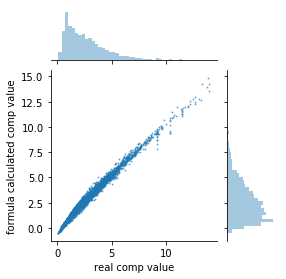

In [49]:
import seaborn as sns
ax = sns.jointplot(y_test, y_CV_CA, s=1, alpha=0.5, height=4, ratio=3)
ax.set_axis_labels('real comp value', 'formula calculated comp value', fontsize=10);

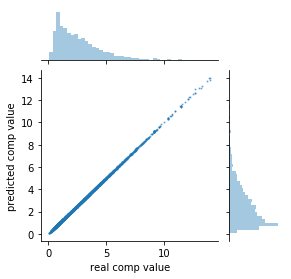

In [50]:
ax = sns.jointplot(y_test, test_predictions, s=1, alpha=0.5, height=4, ratio=3)
ax.set_axis_labels('real comp value', 'predicted comp value', fontsize=10);

From the above two plots it can be seen that there is less scattering for the predicted competition value than for the computed competition value. So the machine learning evaluates in a good sense.

The next plots show the difference of: 
- calculated value and the real value for the CV in relation to the real value.
- predictions and the real value for the CV in relation to the real value.

standard deviation: (CV_CA - real comp value): 0.2942


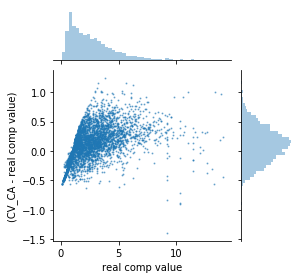

In [51]:
ax = sns.jointplot(y_test, (y_CV_CA - y_test), s=1, alpha=0.5, height=4, ratio=3)
ax.set_axis_labels('real comp value', '(CV_CA - real comp value)', fontsize=10);
print('standard deviation: (CV_CA - real comp value): {:.4f}'.format((y_CV_CA - y_test).std()))

standard deviation: (predictions - real comp value): 0.0158


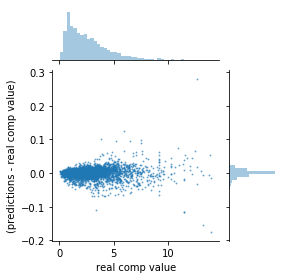

In [52]:
ax = sns.jointplot(y_test, (test_predictions - y_test), s=1, alpha=0.5, height=4, ratio=3)
ax.set_axis_labels('real comp value', '(predictions - real comp value)', fontsize=10);
print('standard deviation: (predictions - real comp value): {:.4f}'.format((test_predictions - y_test).std()))

**Interpretation:** Visulization that the predictions are closer to the real value than the Swisstennis calculations with the formula. Standard deviation for the (predictions - real value) is very low.

### 6.2) Discussion of the formula

The formulas for the competition value (CV) and risk award (RA) are identical, there is just a linear factor which is different.
Let's study the CV formula. The CV formula can be used as a baseline, it just has some additional hidden functionality which is not known, but it can serve to help to understand how to become a better player, or at least on how to get a better ranking and what role the input parameters play for the ranking.
Here is the formula again:

![title](./03_image/compvalue_formula.png)

`Reminder: `
- w-values are the competition values: (W = Wettkampf Wert). w0 not be be confused with the W0 in the feature matrix is here in this formula the competition value of the discussed player. In the feature matrix this value is CV_PrevW (previous competition value). wj are values of the opponents. The first ln-sum on the left side addresses the victories and the second ln-sum the defeats.

The following questions shall be answered:
- how do victories change the competition values in relation to defeats ?
- how does the new CV change in relation to the win/loss ratio ?
- what happens if a player loses or wins against against against much weaker players ?

For this purpose let's choose a hypothetic player called "A" has a (previous) competition value of c (in the below sample c = 8). All his opponents he plays against also have the competition value of c. What happens if that loses ? What happens if he wins ? Those question always according to the formula.

In the following sample I will simulate a players which wins x -times an loses y-times. The x-axis of the plot below can be interpreted as the number of won matches and the y-axis as the number of lost matches.


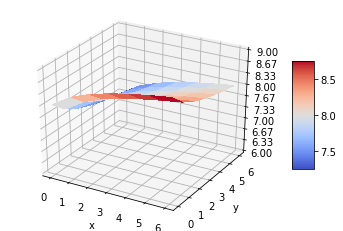

In [53]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# this function receives a meshgrid as inputd and the competition value c for the players own comp-value and the players opponents
# comp values. the number of win's and defeats are given by the input parameters x and y, and it calculates the new comp-value z,
# according to the forumla.
def calculate(x, y, c, cv_opponents, verbose):
    cv_own = c
    Z=[]
    
    if verbose:
        print('w l new-cv')
        print('==========')
    
    for i in range(len(x)):
        win = np.array([cv_own] + [cv_opponents for x in range(x[i]) ])
        lost = np.array([cv_own] + [cv_opponents for x in range(y[i]) ])
        comp_result = calculate_comp_result(win, lost)
        Z.append(comp_result)
        if verbose:
            print(x[i], y[i], comp_result)
        
    return Z

# plots the results, if verbose is set to True, not only the plot is drawn, also the detailed numbers are printed
def plot_formula_result(c, c_opponent, verbose):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    # create data 
    x = y = np.arange(0, 7, 1)
    X, Y = np.meshgrid(x, y)

    zs = np.array(calculate(np.ravel(X), np.ravel(Y), c, c_opponent, verbose))
    Z = zs.reshape(X.shape)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    
    # Customize the z axis.
    ax.set_zlim(6, 9)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    ax.set_xlabel('x')
    ax.set_ylabel('y')


    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
    
# plot the results
plot_formula_result(8,8,False)

**Interpretation:**
If the hypothetic player loses n times and wins n times against an opponent with the exact same ranking, the ranking does not move. This is difficult to seen in this plot, but it would correspond to the following datapoints (x,y) = (0,0) (1,1) (2,2) (3,3) (4,4) (5,5) and (6,6). But this can be verified by transforming the formula, or by executing the above cell again and changing the verbose parameter from False to True

The curves has not a linear increase. That means. Is is much better to win only one match and having no defeats, instead of 2 wins againts 1 defeat. Even worse (x,y) = (3,2) > (4,3) > (5,4) ....

Otherwise defeats and wins are symetric. 

Assume now that the hypothetic player plays only against much weaker opponents. Say he has a comp-value of 8 and all the opponents all have a much weaker comp-value of 5. This time the numerical output is printed as well.


w l new-cv
0 0 8.0
1 0 8.024293675786872
2 0 8.04746147821048
3 0 8.069603157109729
4 0 8.090805766339681
5 0 8.111145730930268
6 0 8.130690509930908
0 1 6.475706324213129
1 1 6.5
2 1 6.523167802423609
3 1 6.545309481322858
4 1 6.566512090552809
5 1 6.586852055143397
6 1 6.606396834144036
0 2 6.1411320406666485
1 2 6.1654257164535196
2 2 6.188593518877129
3 2 6.210735197776377
4 2 6.231937807006329
5 2 6.2522777715969164
6 2 6.271822550597555
0 3 5.942464112733823
1 3 5.966757788520694
2 3 5.989925590944304
3 3 6.012067269843552
4 3 6.0332698790735035
5 3 6.053609843664091
6 3 6.07315462266473
0 4 5.800667847987671
1 4 5.824961523774542
2 4 5.848129326198151
3 4 5.8702710050974
4 4 5.891473614327351
5 4 5.911813578917939
6 4 5.931358357918578
0 5 5.690326961140658
1 5 5.714620636927529
2 5 5.737788439351139
3 5 5.759930118250387
4 5 5.781132727480339
5 5 5.801472692070926
6 5 5.821017471071565
0 6 5.599988461943858
1 6 5.624282137730729
2 6 5.647449940154338
3 6 5.669591619053587
4 6 5

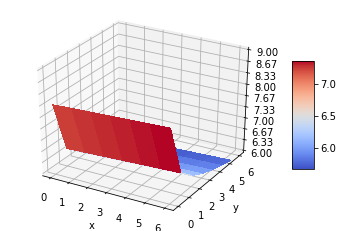

In [54]:
plot_formula_result(8,5,True)

**Interpretation:** when playing only against week players, one have to win many many matches to get a better ranking. And the risk is also very high as if the player loses, the players obtains quickly a worse ranking (the curve in the blue area is quit steep).

In the next cells: simulate a player with a competition value of "5" plays against only players with the same competition value. Study the win/loss ratio for a hypothetical player.

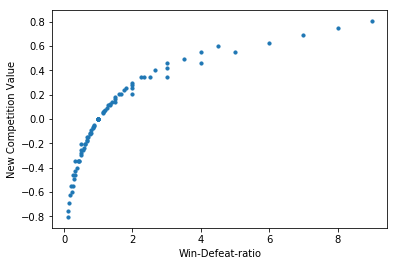

In [55]:
n = 10 ; m= 10;
x = []
y= []
for i in range(1, n):
    for j in range(1, m):
        x.append(i)
        y.append(j)
new_comp_value = calculate(x, y, 5, 5, False)      

# calculate win-ratio 
win_ratio = []
for i in range(len(x)):
    win_ratio.append(x[i]/y[i])
    
plt.scatter(win_ratio, np.array(new_comp_value) - 5 , s=10)
plt.xlabel('Win-Defeat-ratio')
plt.ylabel('New Competition Value')
plt.show()

**Interpretation:** For a given win-loss (or win-defeat) ratio, there are several points. 
For instance Win-defeat-Ratio = 4: it has two points. The lower one is 4:1 (4 matches won, and 1 lost) and the upper one is 8:2 (8 matches won, 2 matches lost). So at least for a having a given win-loss ratio, it is better to have mor matches won. This is intuitivly a fair ranking classification.

### 6.3) Input data

Let's have a look at the collected data:

Take only players who have 0 lost matches and 'n' won matches. And see what their jump from the previous competition value to the current comp-value is:

In [56]:
# get only the players who have 0 defeats. And calculate the number of won matches and the delta value from the competition value
# column 'N_W': number of won matches, CV_diff: the difference of the new comp-value to the previous comp-value
def get_only_winning_players(df):
    # check the lost matches
    columns_loss = ['L'+ str(x) for x in list(range(nbr_of_columns -1))]
    loss = df[columns_loss].values
    
    columns_win = ['W'+ str(x) for x in list(range(nbr_of_columns -1))]
    win = df[columns_win].values
    
    # for data collection
    ids = df.Id ; cv_prev = df.CV_PrevW ; cv_current = df.CV_C
    
    rows = []
    for i in range(loss.shape[0]):
        # get the number of won matches
        win_arr = win[i]
        win_arr = win_arr[win_arr > 0]
        
        # get the number of lost matches
        loss_arr = loss[i]
        loss_arr = loss_arr[loss_arr > 0]
        
        if len(loss_arr) == 0:
            row = np.array([ids[i], len(win_arr), cv_current[i], cv_prev[i], cv_current[i] - cv_prev[i]])
            rows.append(row)
    
    df = pd.DataFrame(rows, columns=['Id', 'N_W', 'CV_C', 'CV_PrevW', 'CV_diff'])         
    return df.apply(pd.to_numeric)

For all the players who have won n matches (and lost 0 matches), calculate the mean of the comp-value difference and display it.

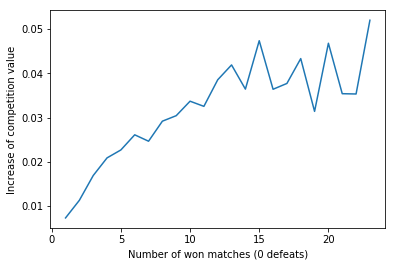

In [57]:
df = get_only_winning_players(data)
df_grouped = df.groupby('N_W')
n = 24

plt.plot([x for x in range(1,n)], [df_grouped.get_group(i)['CV_diff'].mean() for i in range(1, n)])
plt.xlabel('Number of won matches (0 defeats)')
plt.ylabel('Increase of competition value')
plt.show()


**Interpretation:** verifiying the plot, the first question which comes to mind is: why are some decreasing points in this plot ? Should the curve always be increasing ? Not necessarily, the players play against opponents which have different competition values, so it cannot directly be compared to the plots above, where the hypothetic tennis player faces just opponents with the same competition value. In general this curve here is increasing, the higher the value on the x-axis, the dataset becomses sparse as it there are not many players who won 20 matches and have 0 defeats.

Before further analyzing the input features, we try to do some additional feature engineering:

### 6.4) Additional Feature Engineering

As previously seen:
- the win-ratio is important for a better ranking
- the competiton value of the opponents as well

Therefore I add additional features as:
- win - defeat ratio.
- average of the opponents (won and lost matches)

Currently In the data object, all the victories are aligned in die columns W0 ... W80 and the defeats in the columns L0 ... L80. The values are 0 if no match was played. For instance a player who won two matches has values in W0 and W1 and all the other columns are set to 0. The victories and defeats are listet according to the date they were played. Let's imagine two players of exactly the same level, if Player1 wins against a strong and then weak player and Player2 wins against a weak and then a strong player, their features W1 and W2 do not encode the same type of information. So I introduce an ordering of the values, that means: W0 always contains the value of the strongest opponent, W1 against the 2nd best players. The same for the defeats.



### Supportive Functions

Following are some helper functions to order the values of the victories and defeats and to add the additional features

In [58]:
# orders the W0 ... W75 and L0 ... L75 columns with the matches of the highest values first
# at the end, the same dataframe is reconstructed and returned
def order_matches(df):
    # get the winning columns
    columns_win = ['W'+ str(x) for x in list(range(nbr_of_columns -1))]
    win = df[columns_win].values
    win.sort(axis=1) 
    win = win[:, ::-1] 
    win_pd = pd.DataFrame(win, columns=columns_win)
    
    # do the same for the losing columns
    columns_lost = ['L'+ str(x) for x in list(range(nbr_of_columns -1))]
    lost = df[columns_lost].values
    lost.sort(axis=1)
    lost = lost[:, ::-1] 
    lost_pd = pd.DataFrame(lost, columns=columns_lost)
    
    # get the columns which were not affected which are at the beginning
    columns_remaining = np.setdiff1d(np.array(df.columns) , np.array(columns_win + columns_lost + ['CV_PrevW', 'CV_PrevL']))
    df1= df[columns_remaining]
    df2 = df['CV_PrevW'].to_frame()
    df3 = df['CV_PrevL'].to_frame()
    # stick together the initial dataframe
    return pd.concat([df1,df2, win_pd, df3, lost_pd], sort=False, axis=1)

In [59]:
# this function creates additional features within the data dataframe
def add_features(df):
    columns_win = ['W'+ str(x) for x in list(range(nbr_of_columns -1))]
    win = df[columns_win].values
    prev_comp_values = df['CV_PrevW'].values
    
    columns_loss = ['L'+ str(x) for x in list(range(nbr_of_columns -1))]
    loss = df[columns_loss].values
    
    new_rows = []    # container for all new features in this row
    # iterate over all rows
    for i in range(win.shape[0]):
        # get the mean of the won matches
        win_arr = win[i]
        win_arr = win_arr[win_arr > 0]
        
        if len(win_arr) != 0:
            win_mean = win_arr.mean()
        else:
            win_mean = 0  # set to 0 when no matches were won
            
        # get the mean of the lost matches
        loss_arr = loss[i]
        loss_arr = loss_arr[loss_arr > 0]
        
        if len(loss_arr) != 0:
            loss_mean = loss_arr.mean()
        else:
            loss_mean = 0  # set to 0 when no matches were lost
        
        # define win/defeat ratio:
        if len(loss_arr) != 0:
            win_loss_ratio = len(win_arr) / len(loss_arr)
        else:
            win_loss_ratio = len(win_arr) + 2  # just set the number of won matches + a bonus value
        
        prev_cv = prev_comp_values[i]
        
        # calculate std of the current player
        p_std = np.append(win_arr, loss_arr).std()
        
        win_arr = np.append(win_arr, [prev_cv])
        loss_arr = np.append(loss_arr, [prev_cv])
        
        # also calculate the cumulated sums
        win_sum =  np.log(sum([math.exp(x) for x in win_arr]))
        loss_sum = np.log(sum([math.exp(-x) for x in loss_arr]))
        
        row = np.array([p_std, win_sum, loss_sum, win_mean, loss_mean, win_loss_ratio])
        new_rows.append(row)
   
    new_columns = ['P_std', 'W_sum', 'L_sum', 'W_mean', 'L_mean', 'W_L_ratio']
    new_features = pd.DataFrame(new_rows, columns=new_columns)   
    
    # stick together the original dataframe
    columns_remaining = np.setdiff1d(np.array(df.columns) , np.array(columns_win + columns_loss + ['CV_PrevW', 'CV_PrevL']))
    df1= df[columns_remaining]
    df2 = df['CV_PrevW'].to_frame()
    df3 = df['CV_PrevL'].to_frame()
   
    new_df = pd.concat([df1,new_features, df2, df[columns_win], df3, df[columns_loss]], sort=False, axis=1)
    new_df['Id'] = new_df['Id'].apply(pd.to_numeric)
    return new_df

In [60]:
# helper functions to visualize the correlation of two columns
def correlation_visualization(df, col1, col2):
    # get the correlation of the values
    correlation = df[col1].corr(df[col2])
    
    # print only a subset for better visibility
    df = df.sample(frac=0.001,random_state = 0) 
    
    # plot
    ax = sns.pairplot(x_vars = col1, y_vars = col2, data = df, height = 3)
    ax.set(ylabel='Delta competition value')
    plt.title('Correlation: {:1.2f}'.format(correlation))
    plt.show()

So I create those new features in the function below with the following naming:
- W_mean: the mean of the opponents against the player won.
- L_mean: the mean of the opponents against the player lost.
- W_L_ratio: ratio of the won/lost matches
- W_sum: this is experimental. This is the ln-sum(exp) in the competition value formula for the won matches
- L_sum: this is experimental. This is the ln-sum(exp) in the competition value formula for the lost matches

The features W_sum an L_sum is to try if the performance improves, if a "hint" is given to the model. It is clear, that this information is redundant.

The new data matrix is build by:

In [61]:
# order the matches
data_ordered = order_matches(data)

# add the additional features
data_add_features = add_features(data_ordered)

Let us study if there is a correlation between the difference of old CV and new CV and the new features.

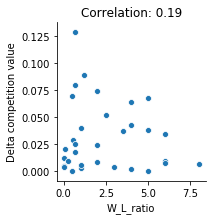

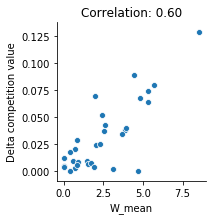

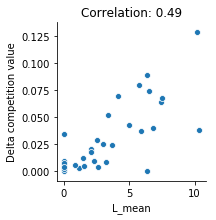

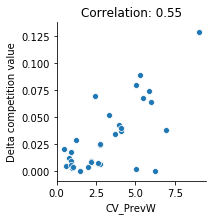

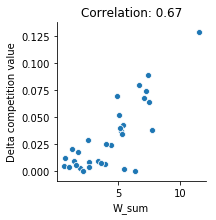

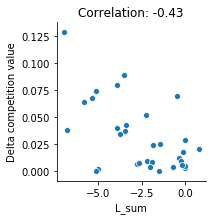

In [62]:
data_add_features['CV_delta'] = data_add_features['CV_C'] - data_add_features['CV_PrevW']

# prints the correlation of the two features and print some datapoints
correlation_visualization(data_add_features, 'W_L_ratio', 'CV_delta')
correlation_visualization(data_add_features, 'W_mean', 'CV_delta')
correlation_visualization(data_add_features, 'L_mean', 'CV_delta')
correlation_visualization(data_add_features, 'CV_PrevW', 'CV_delta')
correlation_visualization(data_add_features, 'W_sum', 'CV_delta')
correlation_visualization(data_add_features, 'L_sum', 'CV_delta')

**Interpretation:** there exists partly high correlations between the new features, so it is possible to get additional value.

### 6.5) Victories and Defeats

Discussion of the importance of victories and defeats. 



In [63]:
df = data_add_features[['GV', 'CV_C', 'CV_PrevW', 'W_L_ratio', 'W_mean', 'W0', 'W1', 'W2', 'W3', 'W4', 'W5','L0', 'L1', 'L2', 'L3', 'L4', 'L5' ]]

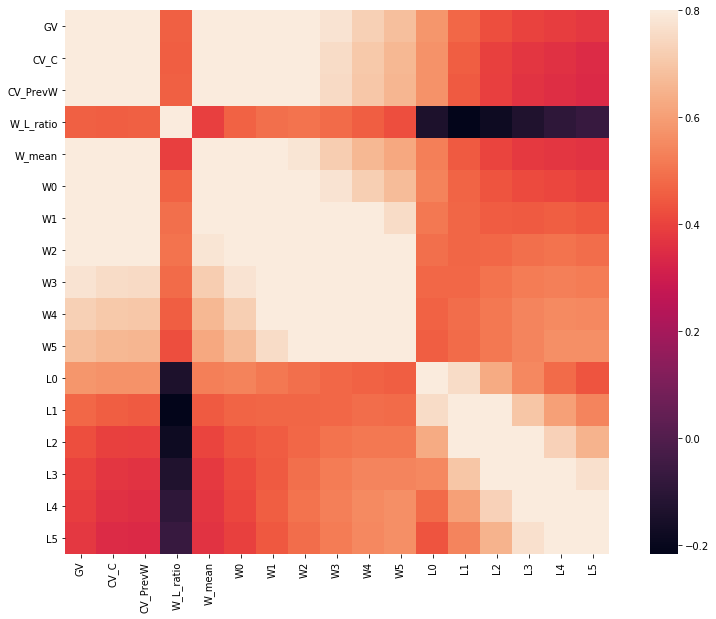

In [64]:
plt.figure(figsize = (15, 10))
sns.heatmap(df.corr(), vmax=.8, square=True);

**Interpretation:** the most important factor is still the previous value (=CVPrevW). This assures that the ascending and the descending of a player is "smooth": We could image a high ranked player (for instance R1) which just plays one match in a season and loses it: this assures that in the next ranking periode he will not have a very low ranking like for instance R5. As the won and lost matches are now ordered the correlation is high for the first W-values. That L0 has a high correlation with the CV_C can be misleading. This mainly says that when a player has a high ranking and normally each one playing regularly also loses, then he loses against players having a high grading.

## 7) Second Analysis for the competition value (CV)

Evaluate the performance of the new features. 
As the execution time of the ridge regression is very short and the best results were obtained with that method in the previous investigations, I will use only ridge regression for the analysis of the different combinations. Neural network and random forest will be used for the best feature combination later on.

### 7.1) Ridge Regression

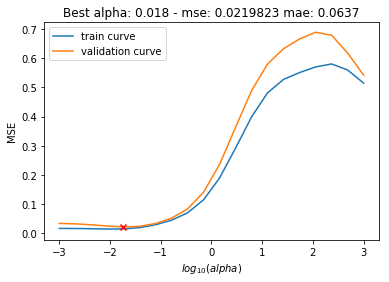

best alpha: 0.018
MAE for ridge regression: 0.0679186


In [65]:
# Create train/test sets
X_train, X_test, y_train, y_test = splitdata_train_test(data_add_features)

# add all features mentionned previously
_, mae_add_all_features, _ = do_ridge_regression(X_train, X_test, y_train, y_test, True)
print('MAE for ridge regression: {:.7f}'.format(mae_add_all_features))

**Interpretation:** The result is much worse than before. Still better than the baseline. So let us see what are the causes.
In the next step I try to use only the "sum" features. Those features represent the two parts of the formula. So give a try by using only those two features:

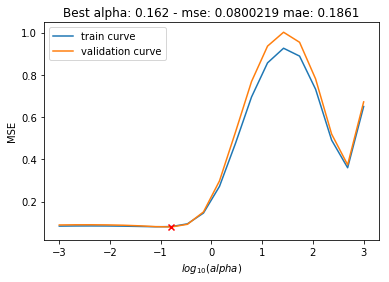

best alpha: 0.162
MAE for ridge regression: 0.1964523


In [66]:
X_train2 = X_train[['W_sum', 'L_sum']]
X_test2 = X_test[['W_sum', 'L_sum']]

_, mae_add_formula_features, _ = do_ridge_regression(X_train2, X_test2, y_train, y_test, True)
print('MAE for ridge regression: {:.7f}'.format(mae_add_formula_features))

Obviously those two features are "responsible" for the bad results. The reason is probably that the carry the same redundant information as the "W" and "L" columns.
Let's see what happens when those features are being removed:

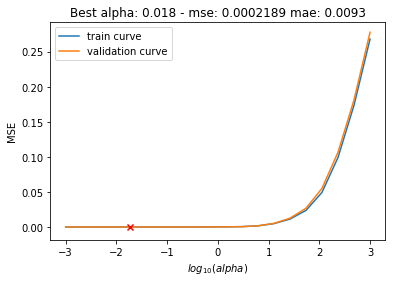

best alpha: 0.018
MAE for ridge regression: 0.0092875


In [67]:
data_add_features = data_add_features.drop(['W_sum','L_sum'], axis=1)

X_train, X_test, y_train, y_test = splitdata_train_test(data_add_features)

mse_ordered, mae_add_features, _ = do_ridge_regression(X_train, X_test, y_train, y_test, True)
print('MAE for ridge regression: {:.7f}'.format(mae_add_features))

So far the best result. With the newly created features and by dropping the sum features, a slight better result than before is achieved. Now use this feature combination for the neural network and random forest:

### 7.2) Neural Network

4000/4000 [==============================] - 0s 13us/step


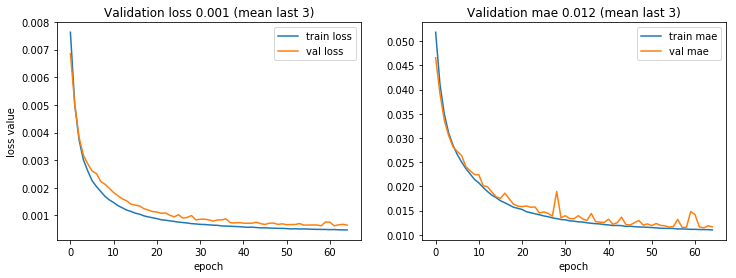

Testing set mean absolute error for a neural network: 0.01185 


In [68]:
mae_nn2, test_predictions, model = do_neural_network(X_train, X_test, y_train, y_test, 0, 64, True)
print("Testing set mean absolute error for a neural network: {:.5f} ".format(mae_nn2))

#### 7.2.1) Neural Network intermediate learning observation
Let's study how the neural network learns the features:  The last dense layers has 64 neurons, I take this layer and apply PCA (primary component analysis) on it to reduce it to the two principal components and visualize it by combining is with the grading value. Both output features of the intermediate layer are nicely separated by category

In [69]:
# some preparation tasks
scaler = MinMaxScaler()
X_train_normed = scaler.fit_transform(X_train)
X_test_normed = scaler.transform(X_test)
df_ranking = X_test.copy()
df_ranking['ranking'] = X_test.index.map(lambda x : player_dict_ranking[x])


In [70]:
# get the intermediate results in the variable intermediate_prediction
model.layers[1]._name='penultima_layer'
model.summary()

# code from: https://androidkt.com/get-output-of-intermediate-layers-keras/
layer_name='penultima_layer'
layer_output=model.get_layer(layer_name).output
intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(X_test_normed)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                10752     
_________________________________________________________________
penultima_layer (Dense)      (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 14,977
Trainable params: 14,977
Non-trainable params: 0
_________________________________________________________________


reduce the intermediate_prediction to two PCA components and visualize it by mapping the grading category to the two principal components.

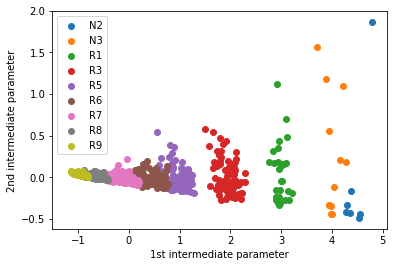

In [71]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_2d = pca.fit_transform(intermediate_prediction, y=None)

df = pd.DataFrame({'X':X_2d[:,0],
                    'Y':X_2d[:,1],
                    'ranking':df_ranking.ranking})

list_ranking = [ 'N2', 'N3', 'R1', 'R3',  'R5', 'R6', 'R7', 'R8', 'R9']
#list_ranking = ['N2', 'R1']
for i in list_ranking:
    df_temp = df[df['ranking'] == i][0:100]
    plt.scatter(df_temp.X, df_temp.Y, label=i)
plt.legend()
plt.xlabel('1st intermediate parameter')
plt.ylabel('2nd intermediate parameter')
plt.show()  



With this two parameters, the rankings are grouped together. And the two princical componentes cover 97% of the information

In [72]:
pca = PCA(n_components=2).fit(intermediate_prediction)
sum(pca.explained_variance_ratio_)

0.9692005049437284

No additional evidence with this ... but cool to visualize.

### 7.3) Random Forest
Again: the result is better with an increase of the numbers of estimators. Directly used 200 of them to get the best result.


In [73]:
# execution time > 2 minutes
mae_rf2, rf = do_random_forest(X_train , X_test, y_train, y_test, False, 200)
print('MAE for random forest comp-value: {:.7f} '.format(mae_rf2))

MAE for random forest comp-value: 0.0094002 


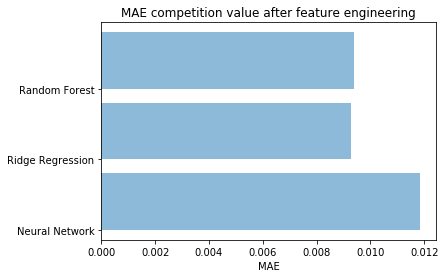

,Method,MAE
0,Neural Network,0.011847
1,Ridge Regression,0.009288
2,Random Forest,0.009400


In [74]:
d = {'Method': ['Neural Network', 'Ridge Regression', 'Random Forest'], 'MAE': [mae_nn2, mae_add_features, mae_rf2]}
df = pd.DataFrame.from_dict(d)
plot_bar(df, 'MAE competition value after feature engineering')
df

**Observation:** these are the best results for the competition value with the smallest MAE

### 7.3.1) Feature importance
Random forest allows to extract the feature importance. So analyze it:

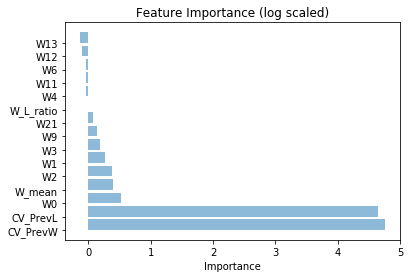

,importance
CV_PrevW,0.560267
CV_PrevL,0.439420
W0,0.000033
W_mean,0.000025
W2,0.000024
W1,0.000018
W3,0.000016
W9,0.000014
W21,0.000012
W_L_ratio,0.000010


In [75]:
n = 15  # number of the most important features
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

# some data transformation
df = feature_importances.reset_index().head(n)
objects = df['index']
y_pos = np.arange(len(objects))
performance = 5 - np.abs(np.log10(df['importance']))

# plot and scale it
plt.barh(y_pos, performance, align='edge', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Importance')
plt.title('Feature Importance (log scaled)')
plt.show()   
feature_importances.head(n)

**Interpretation:** it illustrates again what was previously discussed. The previous feature is the most important one and in comparaison the weight of the single W or L features, the difference is huge.


Now let's play around with those most important features and see what happens if one or more features are dropped. In the first step just try to remove the previous values:

In [76]:
# first only remove one of the previous values
X_train2 = X_train.drop(['CV_PrevW'], axis=1)
X_test2 = X_test.drop(['CV_PrevW'], axis=1)

_, mae_add_formula_features, _ = do_ridge_regression(X_train2, X_test2, y_train, y_test, False)
print('MAE for ridge regression: {:.7f}'.format(mae_add_formula_features))

best alpha: 0.018
MAE for ridge regression: 0.0113644


The result is not that much worse. This is quite clear as the previous is redundant and twice on the feature list. So now remove both previous values from the columns list:

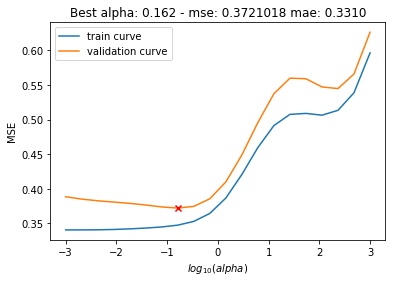

best alpha: 0.162
MAE for ridge regression: 0.3264832


In [77]:
# remove both of the previous values
X_train2 = X_train.drop(['CV_PrevW', 'CV_PrevL'], axis=1)
X_test2 = X_test.drop(['CV_PrevW', 'CV_PrevL'], axis=1)

_, mae_add_formula_features, _ = do_ridge_regression(X_train2, X_test2, y_train, y_test, True)
print('MAE for ridge regression: {:.7f}'.format(mae_add_formula_features))

**Interpretation:** removing fully the previous value completely puts out of track the **MAE**. Now in the following trial, remove the best victory of each player:

In [78]:
X_train2 = X_train.drop(['W0'], axis=1)
X_test2 = X_test.drop(['W0'], axis=1)

_, mae_add_formula_features, _ = do_ridge_regression(X_train2, X_test2, y_train, y_test, False)
print('MAE for ridge regression: {:.7f}'.format(mae_add_formula_features))

best alpha: 0.018
MAE for ridge regression: 0.0094634


as expected: the result is a little worse, but not that far away

## 8) Even more Feature Engineering
In this section I tried some other feature engineering ideas. There were no improvements but I left those here for completion reasons.

### 8.1) First Try: Delta matches

Instead of giving the absolute values of the competition values of the opponents. What happens If we use the difference of the opponents cv and the cv of the player ?

In [79]:
# evaluates the delta of the matches
def delta_matches(df):
    columns_win = ['W'+ str(x) for x in list(range(nbr_of_columns -1))]
    win = df[columns_win].values
    prev_comp_value = df['CV_PrevW'].values 

    # iterate over rows
    for i in range(win.shape[0]):
        prev_cv_value = prev_comp_value[i]

        # iterate over columns
        for j in range(win.shape[1]):
            if win[i,j] != 0:
                win[i,j] = win[i,j] - prev_cv_value

    win_pd = pd.DataFrame(win, columns=columns_win)

    # do the same for the losing columns
    columns_lost = ['L'+ str(x) for x in list(range(nbr_of_columns -1))]
    lost = df[columns_lost].values
    prev_comp_value = df['CV_PrevL'].values

    # iterate over rows
    for i in range(lost.shape[0]):
        prev_cv_value = prev_comp_value[i]

        # iterate over columns
        for j in range(lost.shape[1]):
            if lost[i,j] != 0:
                lost[i,j] = lost[i,j] - prev_cv_value

    lost_pd = pd.DataFrame(lost, columns=columns_lost)

    # get the columns which were not affected which are at the beginning
    columns_remaining = np.setdiff1d(np.array(df.columns) , np.array(columns_win + columns_lost + ['CV_PrevW', 'CV_PrevL']))
    df1= df[columns_remaining]
    df2 = df['CV_PrevW'].to_frame()
    df3 = df['CV_PrevL'].to_frame()

    #stick together the initial dataframe
    return pd.concat([df1,df2, win_pd, df3, lost_pd], sort=False, axis=1)

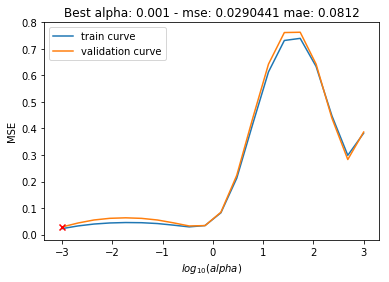

best alpha: 0.001
MAE for ridge regression: 0.0818534


In [80]:
data_delta = delta_matches(data_ordered)
# Create train/test sets
X_train, X_test, y_train, y_test = splitdata_train_test(data_delta)

_, mae_delta, _ = do_ridge_regression(X_train, X_test, y_train, y_test, True)
print('MAE for ridge regression: {:.7f}'.format(mae_delta))

**Interpretation:** no follow up on this idea.

In [81]:
player_dict_std = {}
for index, row in data_add_features.iterrows():
    player_dict_std[row['Id']] = round(row['P_std'], 3)

In [82]:
# this function creates additional features within the data dataframe by setting the std() of each opponent
def add_features_X(df):
    # get the opponent ids of the won matches
    columns_win_opp = ['W_opp'+ str(x) for x in list(range(nbr_of_columns -1))]
    win_opp = df[columns_win_opp].values.astype(float)
    
    # get the opponent ids of the lost matches
    columns_loss_opp = ['L_opp'+ str(x) for x in list(range(nbr_of_columns -1))]
    loss_opp = df[columns_loss_opp].values.astype(float)
    
    # iterate over all rows
    # the already existing W_opp and L_opp will be resused
    for i in range(win_opp.shape[0]):
        # iterate over columns
        for j in range(win_opp.shape[1]):
            if win_opp[i,j] != 0:
                opponent_id = win_opp[i,j]
                if opponent_id < 0:      # foreign result
                    win_opp[i,j] = 1
                else:
                    # set the std() of the opponent
                    opponent_std = player_dict_std[opponent_id]
                    win_opp[i,j] = opponent_std
                
        
        for k in range(loss_opp.shape[1]):
            if loss_opp[i,k] != 0:
                opponent_id = loss_opp[i,k]
                
                if opponent_id < 0:    # foreign result
                    opponent_id = 1
                else:
                    # set the std() of the opponent
                    loss_opp[i,k] = player_dict_std[opponent_id]
    
    win_pd = pd.DataFrame(win_opp, columns=columns_win_opp)
    loss_pd = pd.DataFrame(loss_opp, columns=columns_loss_opp)
    
    # get the columns which were not affected which are at the beginning
    columns_remaining = np.setdiff1d(np.array(df.columns) , np.array(columns_win_opp + columns_loss_opp))
    df1= df[columns_remaining]
    #df2 = df['CV_PrevW'].to_frame()
    #df3 = df['CV_PrevL'].to_frame()

    #stick together the initial dataframe
    return pd.concat([df1, win_pd, loss_pd], sort=False, axis=1)


### 8.2) Second try: Standard deviation of the opponents
The standard deviation of the opponents could give a hint, on how diverse an opponent plays. So add for each match as well the std() of the opponent.


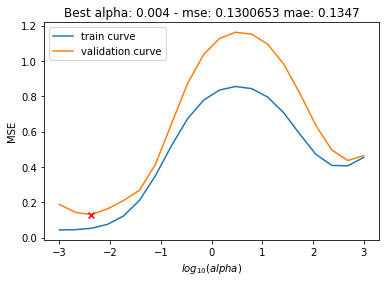

best alpha: 0.004
MAE for ridge regression: 0.1353274


In [83]:
# start from scratch
data = data_original.copy()

# order the data
data_ordered = order_matches(data)

# add the features and remove those features which were useless
data_add_features = add_features(data_ordered).drop(['W_sum','L_sum'], axis=1)

# add the new features of the function above
data_add_features2 = add_features_X(data_add_features)

# Create train/test sets
X_train, X_test, y_train, y_test = splitdata_train_test(data_add_features2)

# regression task
_, mae_add_ext_features, _ = do_ridge_regression(X_train, X_test, y_train, y_test, True)
print('MAE for ridge regression: {:.7f}'.format(mae_add_ext_features))

**Interpretation:** The regressor seem to be "worried" about those new information. No follow-up on this idea.

## 9) Analysis of the Risk Award (RA) 
And the formula for the risk value is as follows:

![title](./03_image/riskvalue_formula.png)

A verification for the risk award with the best features and see what the conclusions are.

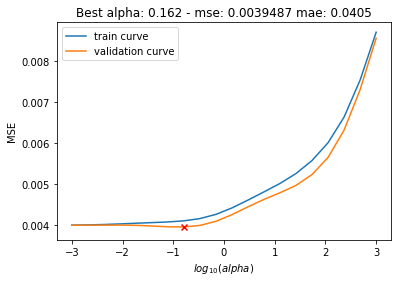

best alpha: 0.162
MAE for ridge regression: 0.0416036


In [84]:
# start from scratch
data = data_copy.copy()

# order the data
data_ordered = order_matches(data)

# add the features and remove those features which were useless
data_add_features = add_features(data_ordered).drop(['W_sum','L_sum'], axis=1)

X_train, X_test, y_train, y_test = splitdata_train_test(data_add_features, 'RA_C')

_, mae_ridge_ra, _ = do_ridge_regression(X_train, X_test, y_train, y_test, True)
print('MAE for ridge regression: {:.7f}'.format(mae_ridge_ra))

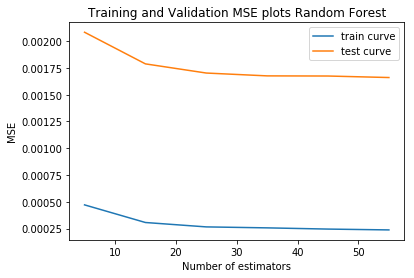

best number of estimators 55
MAE for random forest comp-value: 0.0206996


In [85]:
mae_rf_ra, rf = do_random_forest(X_train , X_test, y_train, y_test, True, range(5, 60, 10))
print('MAE for random forest comp-value: {:.7f}'.format(mae_rf_ra))

4000/4000 [==============================] - 0s 16us/step


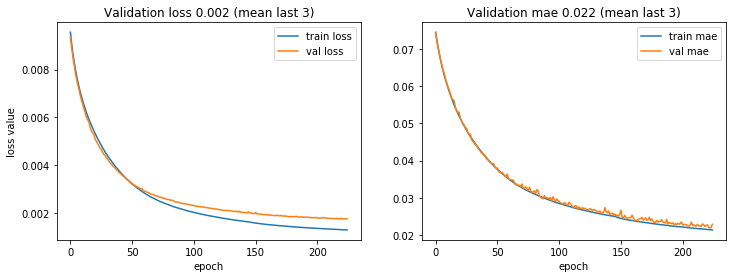

Testing set mean absolute error for a neural network: 0.0231810 


In [86]:
mae_nn_ra, test_predictions, history = do_neural_network(X_train, X_test, y_train, y_test, 0, 32, True)
print("Testing set mean absolute error for a neural network: {:5.7f} ".format(mae_nn_ra))

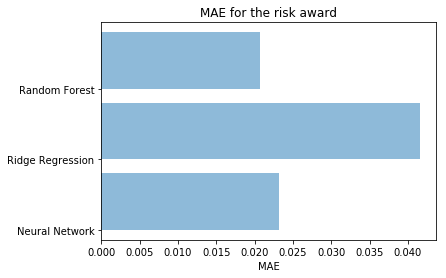

,Method,MAE
0,Neural Network,0.023181
1,Ridge Regression,0.041604
2,Random Forest,0.020700


In [87]:
d = {'Method': ['Neural Network', 'Ridge Regression', 'Random Forest'], 'MAE': [mae_nn_ra, mae_ridge_ra, mae_rf_ra]}
df = pd.DataFrame.from_dict(d)
plot_bar(df, 'MAE for the risk award')
df

**Interpretation:** the results are less accurate than for the competition value. As the final grading value is the addition of the CV and the RA, this will also be less accurate. See the conclusion part of a possible explanation of this.

Also the scattering is higher this time:

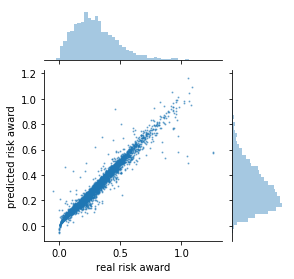

In [88]:
ax = sns.jointplot(y_test, test_predictions, s=1, alpha=0.5, height=4, ratio=3)
ax.set_axis_labels('real risk award', 'predicted risk award', fontsize=10);

## 10) Analysis of the Grading Value (GV)
Try if we get the same accurate values for the final grading value which determines the final ranking and grading.

In [89]:
data = data_copy.copy()

# order the data
data_ordered = order_matches(data)

# add the new features
data_f = add_features(data_ordered).drop(['W_sum','L_sum'], axis=1)

X_train, X_test, y_train, y_test = splitdata_train_test(data_f, 'GV')

_, mae_ridge_gv, _ = do_ridge_regression(X_train, X_test, y_train, y_test, False)
print('MAE for ridge regression: {:.7f}'.format(mae_ridge_gv))

best alpha: 0.695
MAE for ridge regression: 0.0572448


In [90]:
# execution time > 2 minutes
mae_rf_gv, rf = do_random_forest(X_train , X_test, y_train, y_test, False, 200)
print('MAE for random forest comp-value: {:.7f}'.format(mae_rf_gv))

MAE for random forest comp-value: 0.0251747


4000/4000 [==============================] - 0s 13us/step


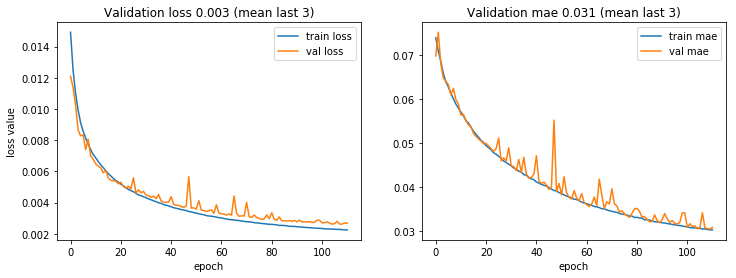

Testing set mean absolute error: 0.032 


In [91]:
mae_nn_gv, test_predictions, history = do_neural_network(X_train, X_test, y_train, y_test, 0, 64, True, 1000)
print("Testing set mean absolute error: {:5.3f} ".format(mae_nn_gv))

In [92]:
data.head()

,Id,Name,GV,RA_CA,RA_C,CV_CA,CV_C,CV_PrevW,W0,W1,...,L71,L72,L73,L74,L75,L76,L77,L78,L79,L80
0,1520,Heinrich Schaerer,2.635,0.219,0.243,2.621,2.392,2.383,2.427,1.465,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1525,René Gut,7.061,0.213,0.356,7.305,6.705,6.666,2.545,4.523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1530,Andreas Fischer,4.579,0.454,0.562,4.463,4.017,3.971,2.068,3.614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1531,Andreas Fischer,5.422,0.356,0.604,5.679,4.818,4.767,4.200,2.990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1536,Gian-Andrea Fischer,5.025,0.269,0.467,5.312,4.558,4.504,1.459,5.728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
y_RA_CA = get_whole_set(data, X_test)['RA_CA']

mae_baseline = MAE(y_RA_CA, y_test)
print("Testing set mean absolute error for the baseline risk award: {:5.3f} ".format(mae_baseline)) 

Testing set mean absolute error for the baseline risk award: 2.720 


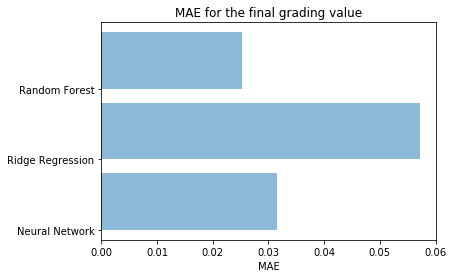

,Method,MAE
0,Neural Network,0.031514
1,Ridge Regression,0.057245
2,Random Forest,0.025175


In [94]:
d = {'Method': ['Neural Network', 'Ridge Regression', 'Random Forest'], 'MAE': [mae_nn_gv, mae_ridge_gv, mae_rf_gv]}
df = pd.DataFrame.from_dict(d)
plot_bar(df, 'MAE for the final grading value')
df

**Interpretation:** in comparaison to the base line, which is:

In [95]:
print('MAE baseline for the final grading value: {:.3f}'.format(mae_baseline))

MAE baseline for the final grading value: 2.720


**Interpretation:** we are still getting good results. Also the scattering is quite small:

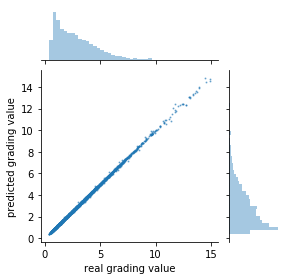

In [96]:
# random forest is the best regressor, do the predictions again and plot the scattering
test_predictions = rf.predict(X_test)
ax = sns.jointplot(y_test, test_predictions, s=1, alpha=0.5, height=4, ratio=3)
ax.set_axis_labels('real grading value', 'predicted grading value', fontsize=10);

## 11) Other Dataset

I collected a dataset two years ago from the ranking periode 1-2018. Verify here if the models trained with the 2-2019 data can be used and applied to an older dataset.

I test this only with ridge regression and the competition value. For this purpose I start again with processing of the 2-2019 so that the same scaler and the same regressor can be applied to the 1-2018 data.

In [97]:
# first: start from scratch
data = data_copy.copy()

# ordering of the data
data_ordered = order_matches(data)

# add additional features
data_add_features = add_features(data_ordered).drop(['W_sum','L_sum'], axis=1)

# split for training
X_train, X_test, y_train, y_test = splitdata_train_test(data_add_features)

# preprocess and add polynomial features
X_train_pre = preprocess(X_train, X_train.columns, 0)
X_test_pre = preprocess(X_test, X_test.columns, 0)

# log transform as variable could be skewed
y_train_pre = np.log10(y_train + 1)
y_test_pre  = np.log10(y_test + 1)

# scale the data
scaler = MinMaxScaler()
X_train_rescaled = scaler.fit_transform(X_train_pre)
X_test_rescaled = scaler.transform(X_test_pre)
        
    
# do ridge regression, no need to do gridsearch for the best alpha this time
alpha = 0.1
ridge = Ridge(alpha=alpha)
ridge.fit(X_train_rescaled, y_train_pre)
    
ridge_mse = MSE(y_test_pre, ridge.predict(X_test_rescaled))
# MSE(y_te, ridge.predict(X_te_rescaled))
ridge_mae = MAE(10**y_test_pre - 1, 10**ridge.predict(X_test_rescaled) - 1)

print('MAE for ridge regression (again) {:.5f}'.format(ridge_mae))

MAE for ridge regression (again) 0.00933


that is the value we have seen already before. Now use this regressor and scaler and verify the result with the new dataset. First load, clean and prepare the data from 1-2018:

In [98]:
# read the player and matches data from 2018
data_p = pd.read_csv('04_data/players-1-2018.csv')
data_m = pd.read_csv('04_data/matches-1-2018.csv', encoding = "utf-8")

# this data needs clean-up. The seasons was from the periode given below, so take only the matches within this periode
data_m = data_m[(data_m.date >= '2017-04-01') & (data_m.date <= '2018-03-31') ]

# data preparation
preparation()
print('Matches shape after cleaning and first processing:', data_m.shape)

# initialize the variable needed for the creation of the main dataframe
init_global_vars()

# create the main dataframe
data, _ = create_data()

# order the matches
data_ordered = order_matches(data)

# add the new features
data_f = add_features(data_ordered).drop(['W_sum','L_sum'], axis=1)

Matches shape after cleaning and first processing: (120323, 11)
# of processed players: 5000
# of processed players: 10000
# of processed players: 15000
# of processed players: 20000
# of processed players: 25000
# of processed players: 30000


In [99]:
# indexing with the swisstennis-id
data_f['Id'] = data_f['Id'].apply(pd.to_numeric)
data_f.set_index('Id', inplace = True)
    
col_win_or_lost = get_W_or_L_columns(data_f)
    
# the columns which are at the head
columns_head = np.setdiff1d(np.array(data_f.columns) , np.array(col_win_or_lost + ['CV_PrevW', 'CV_PrevL']))

# keep a copy to calculate the baseline
data_f_copy = data_f.copy()

y_test = data_f['CV_C']
data_f = data_f.drop(columns_head , axis = 1)

X_test_pre = preprocess(data_f, data_f.columns, 0)
X_test_rescaled = scaler.transform(X_test_pre)
y_test_pre = np.log10(y_test + 1)

mae_old_set = MAE(10**y_test_pre - 1, 10**ridge.predict(X_test_rescaled ) - 1)
print('Baseline for the competition value for season 1-2018 : {:.5f}'.format(MAE(data_f_copy.CV_CA, data_f_copy.CV_C)))
print('MAE for ridge regression for season 1-2018           : {:.5f}'.format(mae_old_set))
data = data_copy.copy()

Baseline for the competition value for season 1-2018 : 0.22896
MAE for ridge regression for season 1-2018           : 0.00986


we are getting again a similar excellent **MAE** as before. So the models are not only valid for one periode but can also be applied in general.

## 12) Conclusion

**To summarize** what has been found out in this project:
    
Machine learning technology can be applied for this use case to predict future rankings. All the regressors delivered more accurate results than the baseline, which were the Swisstennis formula. We can get around this Swisstennis "hidden magic". The goal was not find out on how this "hidden magic" operates (this would rather be for a mathematician), but to see how close it is feasible to be from the right results. 

The naive feature matrix which is just a list of columns for victories and defeats was aleady a good starting point. It was hard to find additional feature to improve the MAE. The strongest feature is certainly the current competition value of the player. All the new values circle this initial value.

The collected data was from october 2019 when the ranking periode or the new season "2-2019" startet. The calculation done by Swisstennis beginning of october is done several times. That means: they do one run and adjust the competition and risk award value and all the players are getting new values. Then this is done a second and a third time and those values are also adjusted. From the data I got, I could only get the previous data and the new competition value of the last run. It would have been much better to own the data before october 2019 and have the previous competition value before the first run, but unfortunately I did not get a response from Swisstennis for my request. So this can only be done in April.

The predictions have some outliers but the standard deviation is rather small. The risk award is less accurate than the competition value. One reason could be that may be the risk award is calculated from the competition value of the first run. But Swisstennis is rather reluctant giving such informations. I will be able to find it out on the next ranking periode when comparing the dataset of 2-2019 with the periode 1-2020.

The regressors random forest and ridge did a fairly good job.

To answer the initial question or problem: Yes, it is possible to do accurate predictions for Swisstennis rankings.

**Possible next steps:**
- do the predictions after april and comparing the previous season 2-2019 with the first season 1-2020 which starts from April 1st. 
- verify the performance of the regressors with this data.
- collect the new data of the played matches on a weekly basis.
- do real predictions throughout the whole year at any date.
- create a (GET-) RESTful Service to enable online requests and launch it on a cloud platform

But this is enough material for another project.

**About the project idea:**
I started two years ago with the java program to screen scrap the Swisstennis webpages and I knew that Swisstennis had a formula to calculate the new rankings. I did not go so far with the screen scaping program and had to finish it for the purpose of this project. My initial idea was to be able to calculate the new ranking according to the Swisstennis formula. Shortly after I noticed that using this formula did not perfectly work. I compared different seasons and then got in touch with Swisstennis to tell them my observations, that applying the formulas did not work 100%. I got an answer, that there is some other logic to maintain always the same ranges for each ranking category each year. Finally I gave it up till last november/december when I was thinking for a capstone project. 

Another idea I initially had is to do match predictions. But there are already a lot of projects out there which do it with ATP data (international matches) (for instance: https://towardsdatascience.com/predicting-wimbledon-matches-using-neural-network-e2ee4d3dead2). But I wanted to do it with swiss data, but this wasn't possible as I would need to have data for several seasons.

**Approach:**
Before the proposal phase and to verify if my idea was feasible and would lead to any valuable result, I had to finish to some degree the screen scraping java program which was not the most funny part of the project and took me about 8 days. For the proposal I exported those data to a csv file and started with some test notebooks where I already built the initial feature matrix and tried a neural network with keras to do the predictions. From the first test on, this worked quite good and gave better results than the baseline. During the proposal phase Michael Notter gave me many useful hints and general indications for this project, mainly in the area of data exploration.

A german proverb saying: "Nach der Pflicht kommt die Kür". (english: Business before pleasure): after screen scraping, the fun part started with building, cleaning and investigating the data and analyzing the data and the performances with the different models. The neural network did not get any better results when changing the network with more nodes, more hidden layers and different initialization methods or by adding dropout or regularization. The ridge regression worked also very well from the first test on. I tried out to add more polynomial features, but without success for improvement. The ridge regression with the polynomial features, the data transformation to get around of the skewness of the data was done as in the exercises in "01. Applied Machine Learning 1". 

**Final statement:**
I am glad to have found a project with labelled data in a domain I perfectly know.
It was cool to use machine learning methods for that specific problem.